# Capstone Project
## Using Machine Learning in Trading Futures

Cell below is loading data obtained from [quandl.com](https://quandl.com). You can check how the resulting csv file was produced from raw trading data of futures contracts across multiple years. Workbook data-preparation.ipynb contains all the code.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

fee = 1.5

delta = 0.95
account_size = 10000
stop_loss = 550

trading_days_in_year = 252

start_date = datetime.date(year=2006, month=6, day=13)
end_date = datetime.date(year=2018, month=12, day=30)
validation_date = datetime.date(year=2018, month=1, day=1)

gold = pd.read_csv('data/gold_daily.csv', index_col='Date')
gold_cot = pd.read_csv('data/gold_cot.csv', index_col='Date')

corn = pd.read_csv('data/corn_daily.csv', index_col='Date')
corn_cot = pd.read_csv('data/corn_cot.csv', index_col='Date')

coffee = pd.read_csv('data/coffee_daily.csv', index_col='Date')
coffee_cot = pd.read_csv('data/coffee_cot.csv', index_col='Date')

dow = pd.read_csv('data/dow_daily.csv', index_col='Date')
nasdaq = pd.read_csv('data/nasdaq_daily.csv', index_col='Date')

Convert index to date type.

In [2]:
gold.index = pd.DatetimeIndex(data=gold.index)
gold_cot.index = pd.DatetimeIndex(data=gold_cot.index)

corn.index = pd.DatetimeIndex(data=corn.index)
corn_cot.index = pd.DatetimeIndex(data=corn_cot.index)

coffee.index = pd.DatetimeIndex(data=coffee.index)
coffee_cot.index = pd.DatetimeIndex(data=coffee_cot.index)

dow.index = pd.DatetimeIndex(data=dow.index)
nasdaq.index = pd.DatetimeIndex(data=nasdaq.index)

Ensure that dataframe is sorted by index (date).

In [3]:
gold = gold.sort_index(kind='mergesort')
gold_cot = gold_cot.sort_index(kind='mergesort')
corn = corn.sort_index(kind='mergesort')
corn_cot = corn_cot.sort_index(kind='mergesort')
coffee = coffee.sort_index(kind='mergesort')
coffee_cot = coffee_cot.sort_index(kind='mergesort')
dow = dow.sort_index(kind='mergesort')
nasdaq = nasdaq.sort_index(kind='mergesort')

Remove older dataframe - because we are missing COT.

In [4]:
gold = gold.loc[gold.index >= '2006-06-13']
corn = corn.loc[corn.index >= '2006-06-13']
coffee = coffee.loc[coffee.index >= '2006-06-13']

In [5]:
gold_cot.head(10)

,Open Interest,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Swap Dealer Longs,Swap Dealer Shorts,Swap Dealer Spreads,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
Date,,,,,,,,,,,,,,,,
2006-06-13,382474.0,42587.0,128892.0,19370.0,66611.0,22998.0,103211.0,30916.0,46704.0,33230.0,10656.0,58412.0,326513.0,365190.0,55961.0,17284.0
2006-06-20,390281.0,47440.0,126992.0,22404.0,64682.0,25806.0,94632.0,30963.0,48730.0,32947.0,11142.0,64458.0,336417.0,372774.0,53864.0,17507.0
2006-06-27,384321.0,48449.0,121890.0,22425.0,62640.0,25151.0,91042.0,32287.0,49614.0,31307.0,11386.0,59762.0,327749.0,362729.0,56572.0,21592.0
2006-07-03,392868.0,48087.0,122568.0,22720.0,69714.0,26352.0,92545.0,30452.0,50821.0,32874.0,8677.0,63514.0,336914.0,372098.0,55955.0,20771.0
2006-07-11,427008.0,54509.0,130618.0,21840.0,79217.0,28805.0,104213.0,27624.0,54922.0,33165.0,11194.0,70944.0,368398.0,403323.0,58611.0,23685.0
2006-07-18,443519.0,49863.0,131166.0,21681.0,83183.0,33352.0,107413.0,24296.0,62395.0,31760.0,9442.0,74272.0,380737.0,418105.0,62782.0,25414.0
2006-07-25,432413.0,52859.0,133290.0,22956.0,85604.0,28832.0,99087.0,22386.0,64810.0,29740.0,6244.0,73980.0,372265.0,415146.0,60148.0,17266.0
2006-08-01,394609.0,45161.0,135988.0,21250.0,73244.0,23643.0,99330.0,24391.0,54618.0,32195.0,4758.0,57618.0,333815.0,374260.0,60795.0,20350.0
2006-08-08,402899.0,46203.0,142240.0,20703.0,72061.0,24259.0,104600.0,24271.0,57785.0,33123.0,6489.0,57914.0,344587.0,385020.0,58312.0,17880.0


### COT Feature engineering
Determine how far we are from top across last 2 years (730 days).

In [6]:
def percentage_from_max(sr):
    mx = sr.max()
    mn = sr.min()
    return (sr[-1]-mn)/(mx-mn)

def max_positions_percentage(df):
    df['Prod_net_position'] = df['Producer/Merchant/Processor/User Longs'] - df['Producer/Merchant/Processor/User Shorts']
    df['Prod_net_position_perc'] = df.rolling('730d')['Prod_net_position'].apply(percentage_from_max, raw=False)
    df['Money_manager_net_position'] = df['Money Manager Longs'] - df['Money Manager Shorts']
    df['Money_manager_net_position_perc'] = df.rolling('730d')['Money_manager_net_position'].apply(percentage_from_max, raw=False)
    df = df[['Prod_net_position_perc', 'Money_manager_net_position_perc']]
    return df

In [7]:
gold_cot = max_positions_percentage(gold_cot)
corn_cot = max_positions_percentage(corn_cot)
coffee_cot = max_positions_percentage(coffee_cot)

### Williams %R
Create feature with Williams %R indicator

In the end I decided not to use any indicator.

In [8]:
# code from stockstats pypy package
def get_wr(df, n_days):
    """ Williams Overbought/Oversold Index
    WMS=[(Hn—Ct)/(Hn—Ln)] ×100
    Ct - the close price
    Hn - N days high
    Ln - N days low
    :param df: data
    :param n_days: N days
    :return: None
    """
    n_days = int(n_days)
    ln = df['Low'].rolling(min_periods=1, window=n_days,
                           center=False).min()
    hn = df['High'].rolling(min_periods=1, window=n_days,
                            center=False).max()
    column_name = 'wr_{}'.format(n_days)
    column_name = 'wr'
    df[column_name] = (hn - df['Settle']) / (hn - ln) * 100

### Create Targets
Based on the threshold, fee and delta calculate targets used for supervised learning.

In [9]:
def calculate_target(row, threshold):
    global fee, delta, stop_loss
    volatility = (row['Settle']-row['Open'])*delta
    if abs(volatility) > fee + threshold:
        if volatility > 0:
            return 1
        else:
            return -1
    else:
        return 0
    return df


def create_trade_outcomes(df, contracts, threshold):
    ans_df = pd.DataFrame([])
    ans_df['gains'] = (df['Settle'] - df['Open'])*0.95*contracts
    ans_df = pd.concat([ans_df, df[['Open', 'High', 'Low', 'Settle']]*contracts], axis=1)
    ans_df['target'] = ans_df.apply(lambda x: calculate_target(x, threshold), axis=1)
    print(ans_df.head(5))
    return ans_df.shift(-1)

In [10]:
threshold = 500
contracts = 100
gold_gains = create_trade_outcomes(gold, contracts, threshold)
gold_gains_train = gold_gains.loc[gold_gains.index < '2018-1-1']
# gold_gains.head(20)

             gains     Open     High      Low   Settle  target
Date                                                          
2006-06-13 -2251.5  59050.0  59500.0  56550.0  56680.0      -1
2006-06-14  -332.5  57000.0  57550.0  56540.0  56650.0       0
2006-06-15  -304.0  57350.0  57950.0  56950.0  57030.0       0
2006-06-16    47.5  58120.0  58250.0  57050.0  58170.0       0
2006-06-19   -38.0  57280.0  57840.0  57100.0  57240.0       0


In [11]:
# get_wr(gold, 14)
gold = pd.concat([gold, gold_gains[['target']]], axis=1)
gold.head(15)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,target
Date,,,,,,,
2006-06-13,590.5,595.0,565.5,566.8,93899.0,192616.0,0.0
2006-06-14,570.0,575.5,565.4,566.5,68729.0,192917.0,0.0
2006-06-15,573.5,579.5,569.5,570.3,52628.0,193887.0,0.0
2006-06-16,581.2,582.5,570.5,581.7,43947.0,189585.0,0.0
2006-06-19,572.8,578.4,571.0,572.4,27362.0,189168.0,1.0
2006-06-20,572.0,581.0,567.8,580.5,39962.0,187696.0,1.0
2006-06-21,577.0,591.5,573.5,591.0,43918.0,187072.0,0.0
2006-06-22,588.0,593.5,584.5,585.4,42916.0,187027.0,1.0
2006-06-23,574.5,589.0,574.5,588.0,33705.0,181290.0,0.0


### Trade gains investigation

Ivestigate trade gains
- have a look at all gains (regardless of label)
- analyze gains for long trades (label 1)
- analyze gains for short trades (label -1)

### Trade labels distribution

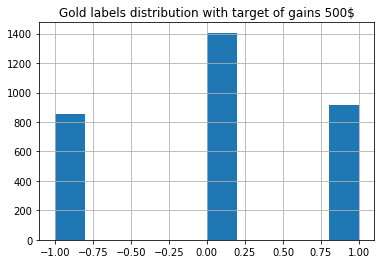

In [12]:
from matplotlib.pyplot import savefig

ax = gold['target'].hist()
ax.set_title('Gold labels distribution with target of gains 500$')
savefig('figures/gold_target_distribution.eps')

In [13]:
gold_gains_train.gains.describe()

count     2921.000000
mean        -6.878637
std       1225.716089
min     -11390.500000
25%       -560.500000
50%         28.500000
75%        627.000000
max       6555.000000
Name: gains, dtype: float64

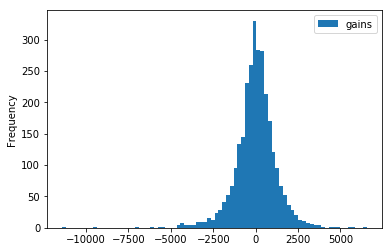

In [14]:
gold_gains_train[['gains']].plot.hist(bins=80)

In [15]:
def stop_loss_gen(df):
    df['Open_High'] = df['High'] - df['Open']
    df['Open_Low'] = df['Open'] - df['Low']
    return df

In [16]:
gold_gains_train = stop_loss_gen(gold_gains_train)

/home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
def plot_histogram_cumsum(df, column):
    df[column].hist(bins=50, density=True, cumulative=-1, figsize=(10,5))
    df[column].hist(bins=50, density=True, linewidth=1.5, cumulative=True, histtype='step', figsize=(10,5))
    ax = plt.plot([0, df[column].max()], [0.9, 0.9], lw=1, color='r')
    return ax

### Investigate suitable stop-loss value

Below are cumulative curves.
Red line denotes 90% mark. What stop-loss should you use when you want 90% of trades to get completed (trade from open  to close)?

Following curves are investigating stop losses based on the label.

| trade | commodity | stop loss |
|-------|-----------|-----------|
| long  |      gold |      1000 |
| short |      gold |       800 |
| long  |      corn |       300 |
| short |      corn |       300 |
| long  |    coffee |       800 |
| short |    coffee |       800 |



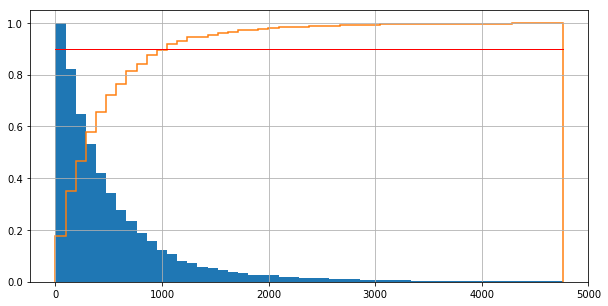

In [18]:
ax = plot_histogram_cumsum(gold_gains_train[gold_gains_train.target == 1], 'Open_Low')
# print(type(ax[0]))
# print(type(ax))
# ax.set_title('Gold stop loss long trades')
savefig('figures/gold_stop_loss_long_trades.eps')

In [19]:
gold_gains_train[gold_gains_train.target == 1].Open_Low.describe()

count     860.000000
mean      472.825581
std       538.691375
min         0.000000
25%       130.000000
50%       310.000000
75%       640.000000
max      4760.000000
Name: Open_Low, dtype: float64

In [20]:
gold_gains_train[gold_gains_train.target == -1].Open_High.describe()

count     802.000000
mean      429.077307
std       439.462157
min         0.000000
25%       150.000000
50%       310.000000
75%       570.000000
max      4380.000000
Name: Open_High, dtype: float64

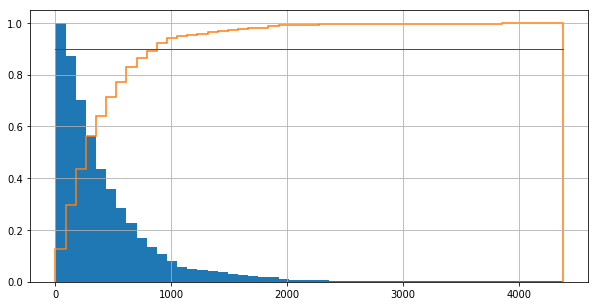

In [21]:
plot_histogram_cumsum(gold_gains_train[gold_gains_train.target == -1], 'Open_High')
savefig('figures/gold_stop_loss_short_trades.eps')

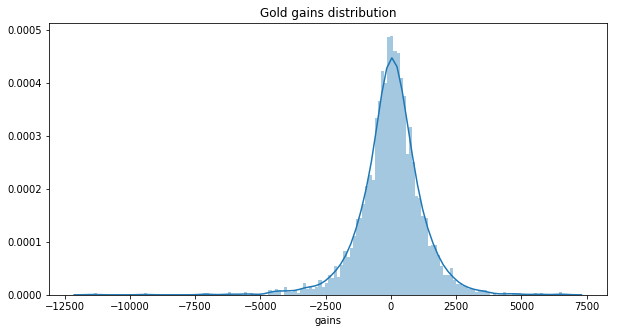

In [22]:
sr = gold_gains_train.gains
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(sr, bins=150, ax=ax)
ax.set_title('Gold gains distribution')
savefig('figures/gold_gains_distribution.eps')

In [23]:
# Corn Contract has 5000 bushels contract is in cents therefore 50 contracts are producing desired values
contracts = 50
threshold = 150
corn_gains = create_trade_outcomes(corn, contracts, threshold)
corn_gains_train = corn_gains.loc[corn_gains.index < '2018-1-1']

              gains     Open     High      Low   Settle  target
Date                                                           
2006-06-13 -213.750  12387.5  12400.0  12112.5  12162.5      -1
2006-06-14 -332.500  12200.0  12262.5  11837.5  11850.0      -1
2006-06-15 -213.750  11875.0  11937.5  11600.0  11650.0      -1
2006-06-16   71.250  12987.5  13137.5  12962.5  13062.5       0
2006-06-19 -154.375  12950.0  13050.0  12750.0  12787.5      -1


In [24]:
corn_gains_train.gains.describe()

count    2917.000000
mean        6.122729
std       411.069273
min     -1983.125000
25%      -190.000000
50%        11.875000
75%       213.750000
max      1888.125000
Name: gains, dtype: float64

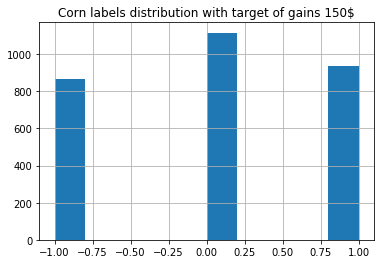

In [25]:
# get_wr(corn, 14)
corn = pd.concat([corn, corn_gains[['target']]], axis=1)

ax = corn.loc[corn.index < '2018-1-1'].target.hist()
ax.set_title('Corn labels distribution with target of gains 150$')
savefig('figures/corn_target_distribution.eps')

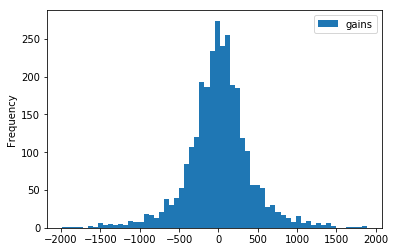

In [26]:
ax = corn_gains_train[['gains']].plot.hist(bins=60)

In [27]:
corn_gains_train.head(10)

,gains,Open,High,Low,Settle,target
Date,,,,,,
2006-06-13,-332.500,12200.0,12262.5,11837.5,11850.0,-1.0
2006-06-14,-213.750,11875.0,11937.5,11600.0,11650.0,-1.0
2006-06-15,71.250,12987.5,13137.5,12962.5,13062.5,0.0
2006-06-16,-154.375,12950.0,13050.0,12750.0,12787.5,-1.0
2006-06-19,-23.750,12825.0,12837.5,12675.0,12800.0,0.0
2006-06-20,142.500,12800.0,12975.0,12775.0,12950.0,0.0
2006-06-21,-95.000,12950.0,13025.0,12800.0,12850.0,0.0
2006-06-22,-83.125,12850.0,12887.5,12737.5,12762.5,0.0
2006-06-23,-225.625,12687.5,12687.5,12387.5,12450.0,-1.0


In [28]:
corn_gains = stop_loss_gen(corn_gains)
corn_gains_train = corn_gains[corn_gains.index < '2018-1-1']

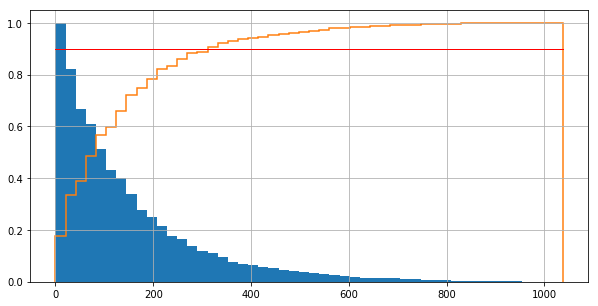

In [29]:
plot_histogram_cumsum(corn_gains_train[corn_gains_train.target == 1], 'Open_Low')
savefig('figures/corn_stop_loss_long_trades.eps')

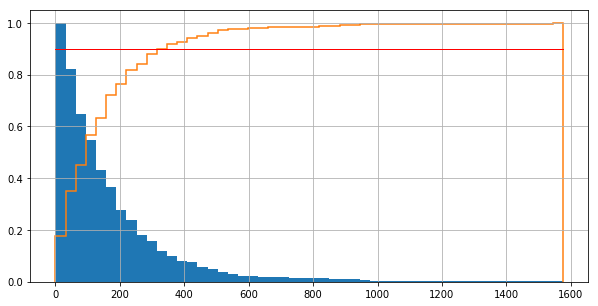

In [30]:
plot_histogram_cumsum(corn_gains_train[corn_gains_train.target == -1], 'Open_High')
savefig('figures/corn_stop_loss_short_trades.eps')

/home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


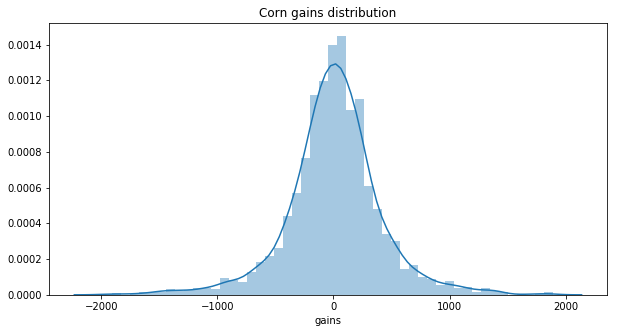

In [31]:
sr = corn_gains_train.gains
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(sr, ax=ax)
ax.set_title('Corn gains distribution')
savefig('figures/corn_gains_distribution.eps')

/home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


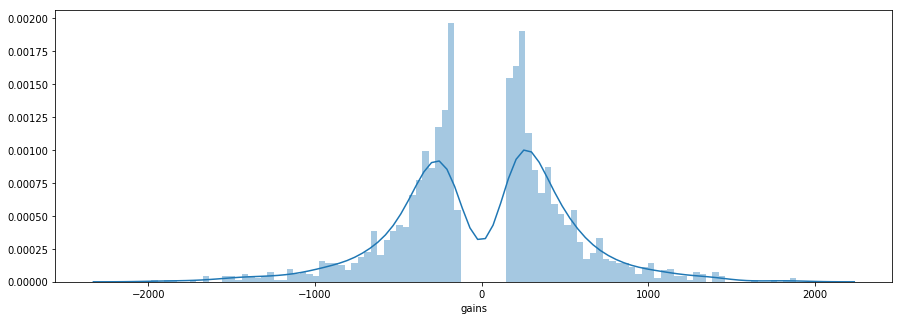

In [32]:
sr = corn_gains_train[corn_gains.gains.abs() > 150].gains
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(sr, bins=100, ax=ax)

In [33]:
# coffee contract size is 37,500 pounds price is in cents per pound
contracts = 375
threshold = 275
coffee_gains = create_trade_outcomes(coffee, contracts, threshold)
coffee_gains = stop_loss_gen(coffee_gains)
coffee_gains_train = coffee_gains.loc[coffee_gains.index < '2018-1-1']

            gains      Open     High      Low    Settle  target
Date                                                           
2006-06-13    0.0  36731.25  37050.0  36712.5  36731.25       0
2006-06-14    0.0  36918.75  37275.0  36600.0  36918.75       0
2006-06-15    0.0  37106.25  37425.0  36937.5  37106.25       0
2006-06-16    0.0  36637.50  37350.0  36337.5  36637.50       0
2006-06-19    0.0  36468.75  36712.5  36375.0  36468.75       0


In [34]:
coffee_gains_train.gains.describe()

count    2908.000000
mean      -11.546273
std      1070.462227
min     -5236.875000
25%      -516.562500
50%         0.000000
75%       498.750000
max      6341.250000
Name: gains, dtype: float64

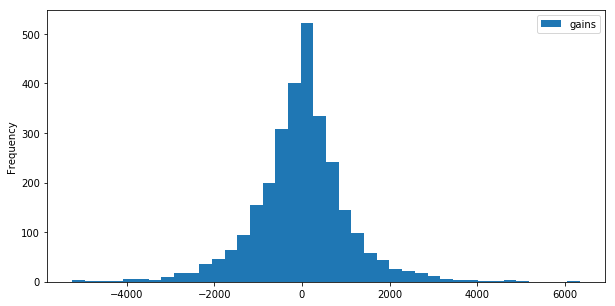

In [35]:
coffee_gains_train[['gains']].plot.hist(bins=40, figsize=(10, 5))

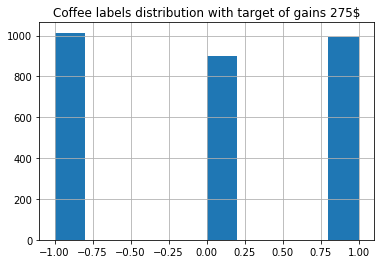

In [36]:
# get_wr(coffee, 14)
coffee = pd.concat([coffee, coffee_gains[['target']]], axis=1)
ax = coffee.loc[coffee.index < '2018-1-1'].target.hist()
ax.set_title('Coffee labels distribution with target of gains 275$')
savefig('figures/coffee_target_distribution.eps')

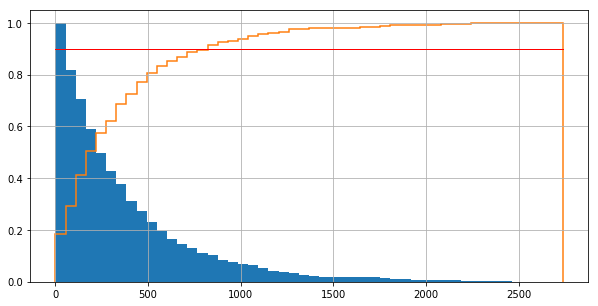

In [37]:
plot_histogram_cumsum(coffee_gains_train[coffee_gains_train.target == 1], 'Open_Low')
savefig('figures/coffee_stop_loss_long_trades.eps')

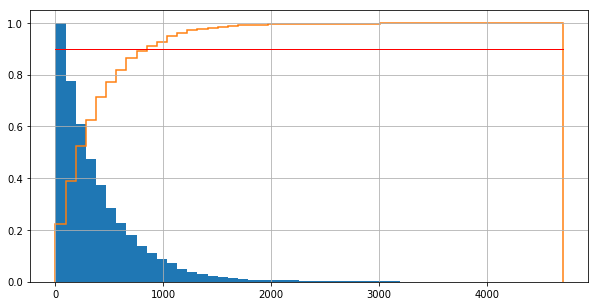

In [38]:
plot_histogram_cumsum(coffee_gains_train[coffee_gains_train.target == -1], 'Open_High')
savefig('figures/coffee_stop_loss_short_trades.eps')

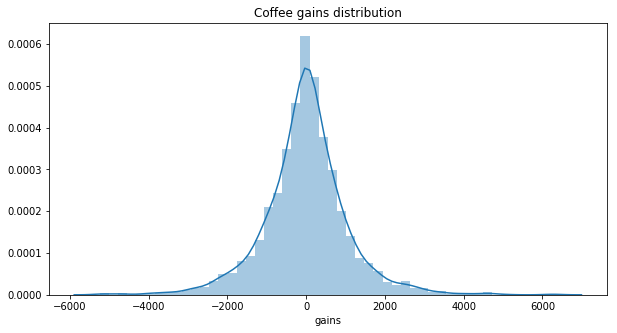

In [39]:
sr = coffee_gains_train.gains
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(sr, ax=ax)
ax.set_title('Coffee gains distribution')
savefig('figures/coffee_gains_distribution.eps')

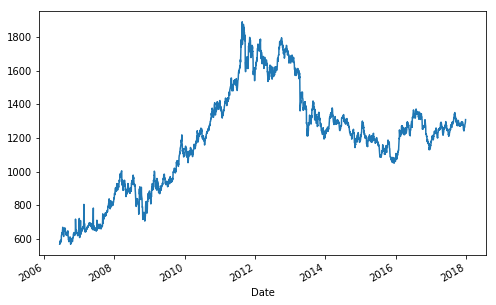

In [40]:
ax = gold.loc[gold.index < '2018-01-01']['Settle'].plot(figsize=(8, 5))
savefig('figures/gold.eps')

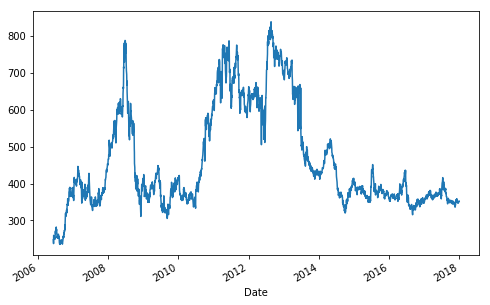

In [41]:
corn.loc[corn.index < '2018-01-01']['Open'].plot(figsize=(8, 5))
savefig('figures/corn.eps')

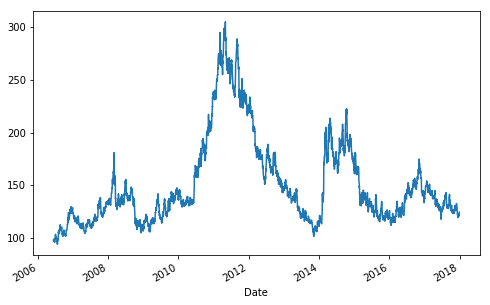

In [42]:
coffee.loc[coffee.index < '2018-01-01']['Open'].plot(figsize=(8, 5))
savefig('figures/coffee.eps')

# Feature Engineering

Code below create date features. In order to capture cyclicality I have transformed features as trading day of month or day of week into $sin$ and $cos$ values.
I am not sure whether this transformation grants subsequent PCA usage.

In [43]:
import numpy as np
import holidays

def trading_day_of_month(tm):
    ts = (tm - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
    dt = datetime.datetime.fromtimestamp(ts)
    di = datetime.date(year=dt.year, month=dt.month, day=1)
    us_holidays = holidays.UnitedStates()
    cnt = 1
    for i in range(1, 32):
        if i == dt.day:
            break
        if di.weekday() in [0, 1, 2, 3, 4] and dt not in us_holidays:
            cnt += 1
        di += datetime.timedelta(days=1)
    return cnt


def create_cycle(x, period):
    sn = np.sin(x*(2.*np.pi/period))
    cs = np.cos(x*(2.*np.pi/period))
    return sn, cs


def create_vectors(df, df_cot):
    global trading_days_in_year
    nv = df.shape[1]-2
    i_t = df.shape[1]-1
    ans_dct = {}
    for i in range(df.shape[0]):
        if i < 2*trading_days_in_year:
            continue
        mtrx = df.iloc[i-2*trading_days_in_year:i, 0:nv].values
        size = np.prod(mtrx.shape)
        mtrx = list(mtrx.reshape(size))
        idx = df.index.values[i]
        # add COT report to the end of list
        mtrx_cot = df_cot[df_cot.index < idx].values[-8:]
        size = np.prod(mtrx_cot.shape)
        mtrx_cot = list(mtrx_cot.reshape(size))
        if size < 16:
            mtrx_cot += [0 for i in range(16-size)]
        # Date Features
        ts = (idx - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
        dt = datetime.datetime.fromtimestamp(ts)
        wsn, wcs = create_cycle(dt.weekday(), 5)
        # period for trading day in month is at most 23
        tsn, tcs = create_cycle(trading_day_of_month(idx), 23)
        dsn, dcs = create_cycle(dt.month, 12)
        qsn, qcs = create_cycle((dt.month-1)//3, 4)
        mtrx_date = [wsn, wcs, tsn, tcs, dsn, dcs, qsn, qcs]
        # mtrx_date = [wsn, wcs, tsn, tcs, dsn, dcs, qsn, qcs, df.loc[idx].wr]
        # mtrx_date = [dt.weekday(), trading_day_of_month(idx), dt.month, (dt.month-1)//3, df.loc[idx].wr]
        # Combine list
        mtrx = mtrx + mtrx_cot + mtrx_date
        mtrx.append(df.iloc[i, i_t])
        ans_dct[idx] = mtrx
    return pd.DataFrame.from_dict(ans_dct, orient='index')

In [44]:
gold_data = create_vectors(gold, gold_cot)
gold_data = gold_data.loc[:end_date]
corn_data = create_vectors(corn, corn_cot)
corn_data = corn_data.loc[:end_date]
coffee_data = create_vectors(coffee, coffee_cot)
coffee_data = coffee_data.loc[:end_date]

cols = list(range(2544))
gold_data_reg = gold_data[cols].join(gold_gains[['gains']].rename(columns={"gains": 2544}))
corn_data_reg = corn_data[cols].join(corn_gains[['gains']].rename(columns={"gains": 2544}))
coffee_data_reg = coffee_data[cols].join(corn_gains[['gains']].rename(columns={"gains": 2544}))

In [45]:
gold_data.tail()

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2018-12-21,1134.0,1138.8,1131.0,1133.2,110023.0,1133.2,1135.5,1128.6,1130.7,115561.0,...,0.346733,-0.951057,0.309017,-0.816970,-0.576680,-2.449294e-16,1.0,-1.0,-1.836970e-16,1.0
2018-12-24,1133.2,1135.5,1128.6,1130.7,115561.0,1130.0,1137.3,1129.5,1133.6,71039.0,...,0.346733,0.000000,1.000000,-0.942261,-0.334880,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.0
2018-12-26,1130.0,1137.3,1129.5,1133.6,71039.0,1135.3,1151.7,1132.8,1138.8,102763.0,...,0.346733,0.587785,-0.809017,-0.979084,0.203456,-2.449294e-16,1.0,-1.0,-1.836970e-16,1.0
2018-12-27,1135.3,1151.7,1132.8,1138.8,102763.0,1139.3,1145.1,1137.1,1140.9,100470.0,...,0.346733,-0.587785,-0.809017,-0.887885,0.460065,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.0
2018-12-28,1139.3,1145.1,1137.1,1140.9,100470.0,1143.1,1160.6,1142.6,1158.1,153065.0,...,0.346733,-0.951057,0.309017,-0.730836,0.682553,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.0


In [46]:
gold_data_reg.head()

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2008-06-06,590.5,595.0,565.5,566.8,93899.0,570.0,575.5,565.4,566.5,68729.0,...,0.698322,-0.951057,0.309017,0.979084,0.203456,1.224647e-16,-1.0,1.0,6.123234e-17,-760.0
2008-06-09,570.0,575.5,565.4,566.5,68729.0,573.5,579.5,569.5,570.3,52628.0,...,0.698322,0.000000,1.000000,0.997669,-0.068242,1.224647e-16,-1.0,1.0,6.123234e-17,-2213.5
2008-06-10,573.5,579.5,569.5,570.3,52628.0,581.2,582.5,570.5,581.7,43947.0,...,0.698322,0.951057,0.309017,0.942261,-0.334880,1.224647e-16,-1.0,1.0,6.123234e-17,1111.5
2008-06-11,581.2,582.5,570.5,581.7,43947.0,572.8,578.4,571.0,572.4,27362.0,...,0.584221,0.587785,-0.809017,0.816970,-0.576680,1.224647e-16,-1.0,1.0,6.123234e-17,-1092.5
2008-06-12,572.8,578.4,571.0,572.4,27362.0,572.0,581.0,567.8,580.5,39962.0,...,0.584221,-0.587785,-0.809017,0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,199.5


Removing Nan from data

In [47]:
gold_data.shape

(2668, 2545)

In [48]:
gold_data = gold_data.dropna()
gold_data.shape

(2668, 2545)

In [49]:
print(corn_data.shape)
corn_data = corn_data.dropna()
corn_data.shape

(2664, 2545)


(2664, 2545)

In [50]:
print(coffee_data.shape)
coffee_data = coffee_data.dropna()
coffee_data.shape

(2655, 2545)


(2655, 2545)

In [51]:
print(gold_data_reg.shape)
gold_data_reg = gold_data_reg.dropna()
gold_data_reg.shape

(2668, 2545)


(2668, 2545)

In [52]:
print(corn_data_reg.shape)
corn_data_reg = corn_data_reg.dropna()
corn_data_reg.shape

(2664, 2545)


(2664, 2545)

In [53]:
print(coffee_data_reg.shape)
coffee_data_reg = coffee_data_reg.dropna()
coffee_data_reg.shape

(2655, 2545)


(2654, 2545)

In [54]:
gold_cot.head(5)

,Prod_net_position_perc,Money_manager_net_position_perc
Date,,
2006-06-13,NaN,NaN
2006-06-20,1.000000,0.000000
2006-06-27,1.000000,0.000000
2006-07-03,0.919154,0.246529
2006-07-11,0.792600,1.000000


In [55]:
gold_data = gold_data.loc[gold_data.index >= '2007-01-01']
corn_data = corn_data.loc[corn_data.index >= '2007-01-01']
coffee_data = coffee_data.loc[coffee_data.index >= '2007-01-01']

gold_data_reg = gold_data_reg.loc[gold_data_reg.index >= '2007-01-01']
corn_data_reg = corn_data_reg.loc[corn_data_reg.index >= '2007-01-01']
coffee_data_reg = coffee_data_reg.loc[coffee_data_reg.index >= '2007-01-01']

In [56]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import FactorAnalysis

validate_date = '2018-01-01'


def data_split_pca_transform(df):
    global validate_date
    label_index = 2544
    df_validate = df.loc[validate_date <= df.index]
    df_data_tt = df.loc[validate_date > df.index]
    df_train, df_test, label_train, label_test = train_test_split(df_data_tt[list(range(label_index))], df_data_tt[label_index], test_size=0.2, random_state=2242)
    
    pca = PCA(n_components=200, random_state=2234)
    # pca = FactorAnalysis(n_components=5, random_state=2234)
    pca.fit(df_train[list(range(label_index))])
    
    return df_train, df_test, label_train, label_test, df_validate[list(range(label_index))], df_validate[label_index], pca


def pca_transform(df, pca):
    label_index = 2544
    df_pca = pca.transform(df[list(range(label_index))])
    
    return df_pca

In [57]:
gold_train, gold_test, gold_label_train, gold_label_test, gold_validate, gold_label_validate, gold_pca = data_split_pca_transform(gold_data)
corn_train, corn_test, corn_label_train, corn_label_test, corn_validate, corn_label_validate, corn_pca = data_split_pca_transform(corn_data)
coffee_train, coffee_test, coffee_label_train, coffee_label_test, coffee_validate, coffee_label_validate, coffee_pca = data_split_pca_transform(coffee_data)

gold_reg_train, gold_reg_test, gold_reg_label_train, gold_reg_label_test, gold_reg_validate, gold_reg_label_validate, gold_reg_pca = data_split_pca_transform(gold_data_reg)
corn_reg_train, corn_reg_test, corn_reg_label_train, corn_reg_label_test, corn_reg_validate, corn_reg_label_validate, corn_reg_pca = data_split_pca_transform(corn_data_reg)
coffee_reg_train, coffee_reg_test, coffee_reg_label_train, coffee_reg_label_test, coffee_reg_validate, coffee_reg_label_validate, coffee_reg_pca = data_split_pca_transform(coffee_data_reg)

# Outlier detection
The code below is using random forest. I am relying on automatic outlier detection.

In [58]:
from sklearn.ensemble import IsolationForest
# from sklearn.neighbors import LocalOutlierFactor

pca_gold = pca_transform(gold_train, gold_pca)
out_gold = IsolationForest(contamination='auto', behaviour='new', random_state=428)
modified_gold = out_gold.fit_predict(pca_gold)

pca_corn = pca_transform(corn_train, corn_pca)
out_corn = IsolationForest(contamination='auto', behaviour='new', random_state=912)
modified_corn = out_corn.fit_predict(pca_corn)

pca_coffee = pca_transform(coffee_train, coffee_pca)
out_coffee = IsolationForest(contamination='auto', behaviour='new', random_state=832)
modified_coffee = out_coffee.fit_predict(pca_coffee)


def remove_outliers(arr, y, isolation):
    lst = out_gold.predict(X)
    a = []
    y_a = []
    for v, h, k in zip(lst, y, X):
        if v == 1:
            a.append(k)
            y_a.append(h)
    a = np.array(a)
    y_a = np.array(y_a)
    return a, y_a

In [59]:
def plot_hist_perc(x):
    df = pd.DataFrame(x)

    ln = df[0].count()
    dct = {}
    dct[-1] = df[df[0] == -1][0].count() / ln
    dct[1] = df[df[0] == 1][0].count() / ln
    
    print('outliers: ' + str(df[df[0] == -1][0].count()))
    print('inliers: ' + str(df[df[0] == 1][0].count()))

    rf = pd.DataFrame.from_dict(dct, orient='index')

    ax = rf.plot(kind='bar', figsize=(10,5), legend=False)
    for i in ax.patches:
        ax.text(i.get_x()-.2, i.get_height()-.05, \
                str(round(i.get_height(),4)), fontsize=15)

outliers: 6
inliers: 1927


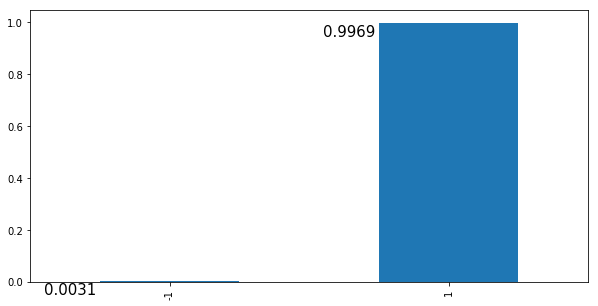

In [60]:
plot_hist_perc(modified_gold)
savefig('figures/gold_outliers.eps')

In [61]:
gold_out = []

for v in pca_gold:
    [p] = out_gold.predict([v])
    if p != 1:
        gold_out.append(v)

In [62]:
gold_out_orig = []

for index, row in gold_train.iterrows():
    [nv] = pca_transform(gold_train.loc[[index]], gold_pca)
    check = [1 for v in gold_out if np.allclose(v, nv)]
    if check:
        print(index)
        gold_out_orig.append(v)

2017-09-25 00:00:00
2017-11-14 00:00:00
2017-11-20 00:00:00
2017-12-05 00:00:00
2017-12-22 00:00:00
2017-12-12 00:00:00


outliers: 15
inliers: 1915


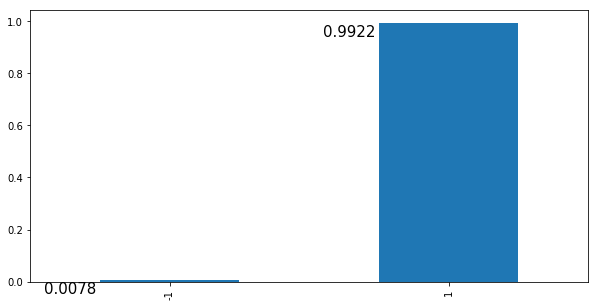

In [63]:
plot_hist_perc(modified_corn)
savefig('figures/corn_outliers.eps')

In [64]:
corn_out = []

for v in pca_corn:
    [p] = out_corn.predict([v])
    if p != 1:
        corn_out.append(v)
        
corn_out_orig = []

for index, row in corn_train.iterrows():
    [nv] = pca_transform(corn_train.loc[[index]], corn_pca)
    check = [1 for v in corn_out if np.allclose(v, nv)]
    if check:
        print(index)
        corn_out_orig.append(v)

2017-06-08 00:00:00
2017-09-28 00:00:00
2017-08-01 00:00:00
2017-03-24 00:00:00
2017-11-13 00:00:00
2017-09-01 00:00:00
2017-09-20 00:00:00
2017-10-30 00:00:00
2017-07-10 00:00:00
2017-06-16 00:00:00
2017-06-26 00:00:00
2017-10-10 00:00:00
2017-09-18 00:00:00
2017-11-02 00:00:00
2017-08-02 00:00:00


Coffee data contains unusually big number of outliers - maybe this could be modified by increasing number of PCA components.

outliers: 346
inliers: 1577


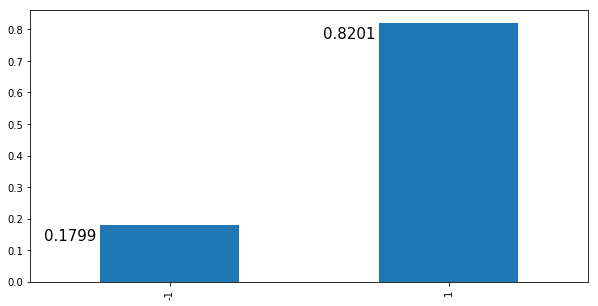

In [65]:
plot_hist_perc(modified_coffee)
savefig('figures/coffee_outliers.eps')

In [67]:
coffee_out = []

for v in pca_coffee:
    [p] = out_coffee.predict([v])
    if p != 1:
        coffee_out.append(v)
        
coffee_out_orig = []

for index, row in coffee_train.iterrows():
    [nv] = pca_transform(coffee_train.loc[[index]], coffee_pca)
    check = [1 for v in coffee_out if np.allclose(v, nv)]
    if check:
        print(index)
        coffee_out_orig.append(v)

2008-06-26 00:00:00
2010-01-07 00:00:00
2009-04-06 00:00:00
2008-08-28 00:00:00
2008-07-02 00:00:00
2008-11-25 00:00:00
2008-12-04 00:00:00
2008-09-16 00:00:00
2010-01-28 00:00:00
2009-08-12 00:00:00
2010-01-08 00:00:00
2008-09-15 00:00:00
2009-09-02 00:00:00
2009-02-09 00:00:00
2009-05-29 00:00:00
2009-07-20 00:00:00
2009-09-18 00:00:00
2009-07-08 00:00:00
2009-02-11 00:00:00
2008-11-03 00:00:00
2009-03-10 00:00:00
2009-12-10 00:00:00
2009-02-02 00:00:00
2009-04-01 00:00:00
2008-08-29 00:00:00
2009-02-20 00:00:00
2008-12-01 00:00:00
2008-12-24 00:00:00
2009-08-17 00:00:00
2009-06-25 00:00:00
2009-08-21 00:00:00
2010-03-02 00:00:00
2008-07-18 00:00:00
2009-08-19 00:00:00
2009-11-30 00:00:00
2008-12-19 00:00:00
2009-11-13 00:00:00
2009-09-08 00:00:00
2009-12-14 00:00:00
2009-06-18 00:00:00
2009-04-17 00:00:00
2009-10-23 00:00:00
2009-02-06 00:00:00
2009-11-03 00:00:00
2009-01-21 00:00:00
2009-05-28 00:00:00
2009-05-11 00:00:00
2008-12-30 00:00:00
2009-01-28 00:00:00
2008-10-20 00:00:00


In [68]:
def create_pca_training(df, df_pca, name, validation=0.2):
    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf['label'] = np.array(list(map(lambda x: x if x >= 0 else 0, df.loc[df.index < '2018-1-1'][2544].values)))
    gdf['label'] = gdf.label.astype(int)
    test_df = gdf.sample(frac=validation)
    test_df = test_df.reset_index()
    test_df = test_df.drop(columns=['index'])
    train_df = gdf.drop(test_df.index)
    train_df = train_df.reset_index()
    train_df = train_df.drop(columns=['index'])
    test_df.to_csv(name + '_long_validation.csv', index=False)
    train_df.to_csv(name + '_long_train.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test['label'] = np.array(list(map(lambda x: x if x >= 0 else 0, df.loc[df.index >= '2018-1-1'][2544].values)))
    gdf_test['label'] = gdf_test.label.astype(int)
    gdf_test.to_csv(name + '_long_test.csv', index=False)

    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf['label'] = np.array(list(map(lambda x: 1 if x < 0 else 0, df.loc[df.index < '2018-1-1'][2544].values)))
    gdf['label'] = gdf.label.astype(int)
    test_df = gdf.sample(frac=validation)
    test_df = test_df.reset_index()
    test_df = test_df.drop(columns=['index'])
    train_df = gdf.drop(test_df.index)
    train_df = train_df.reset_index()
    train_df = train_df.drop(columns=['index'])
    test_df.to_csv(name + '_short_validation.csv', index=False)
    train_df.to_csv(name + '_short_train.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test['label'] = np.array(list(map(lambda x: 1 if x < 0 else 0, df.loc[df.index >= '2018-1-1'][2544].values)))
    gdf_test['label'] = gdf_test.label.astype(int)
    gdf_test.to_csv(name + '_short_test.csv', index=False)


def create_pca_reg_training(df, df_pca, name, validation=0.2):
    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf['label'] = df.loc[df.index < '2018-1-1'][2544].values
    test_df = gdf.sample(frac=validation)
    test_df = test_df.reset_index()
    test_df = test_df.drop(columns=['index'])
    train_df = gdf.drop(test_df.index)
    train_df = train_df.reset_index()
    train_df = train_df.drop(columns=['index'])
    test_df.to_csv(name + '_validation.csv', index=False)
    train_df.to_csv(name + '_train.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test['label'] = df.loc[df.index >= '2018-1-1'][2544].values
    gdf_test.to_csv(name + '_test.csv', index=False)


create_pca_training(gold_data, gold_pca, 'data/gold_pca')
create_pca_training(corn_data, corn_pca, 'data/corn_pca')
create_pca_training(coffee_data, coffee_pca, 'data/coffee_pca')

create_pca_reg_training(gold_data_reg, gold_pca, 'data/gold_pca_reg')
create_pca_reg_training(corn_data_reg, corn_pca, 'data/corn_pca_reg')
create_pca_reg_training(coffee_data_reg, coffee_pca, 'data/coffee_pca_reg')

### Dimension reduction with PCA

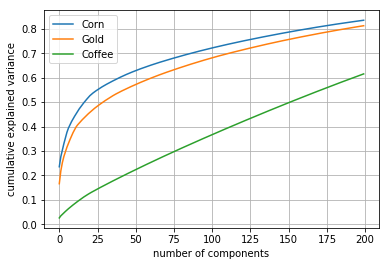

In [69]:
plt.plot(np.cumsum(corn_pca.explained_variance_ratio_), label='Corn')
plt.plot(np.cumsum(gold_pca.explained_variance_ratio_), label='Gold')
plt.plot(np.cumsum(coffee_pca.explained_variance_ratio_), label='Coffee')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid(True)
plt.legend()
# plt.show()
plt.savefig('figures/pca.eps')

It is interesting Corn is best explained by PCA transformation. It is probably due to clear seasonal patterns in trading.

I am surprised that gold is better explained by PCA transformation than Coffee. I would expect that coffee has stronger seasonal trading patterns than gold because of the growth cycle. Maybe gold mining is subject to the weather in similar way as agricultural commodities. Gold is still mostly recycled and new production has limited impact on total amount of traded gold.

Possible explanations:
- corn traded on CME is mostly US produced with stable harvest season
- production of coffee is very unpredictable depending on the conditions of a given year
- there are multiple producers around the world (coffee is more of a global market with limited US production) with different harvest periods https://driftaway.coffee/when-is-coffee-harvested/
- important difference between coffee and corn is price per unit corn is much less efficient to transport
    - 1 kg of corn is worth about 15¢
    - 1 kg of coffee is worth about 230¢
    
Based on this graph I think that PCA transformation is not suitable for coffee. Information in components is growing linearly. If we don't see sharp increase of cumulative explained variance with few first components, then PCA transformation is not suitable. Therefore, coffee should not be considered for trading. I will continue with coffee as well but based on this transformation I would not go ahead with trading unless I would find different transformation.

In [70]:
# np.cumsum(gold_pca.explained_variance_ratio_)[268]

In [71]:
gold_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2008-06-06,590.5,595.0,565.5,566.8,93899.0,570.0,575.5,565.4,566.5,68729.0,...,0.698322,-0.951057,0.309017,0.979084,0.203456,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-09,570.0,575.5,565.4,566.5,68729.0,573.5,579.5,569.5,570.3,52628.0,...,0.698322,0.000000,1.000000,0.997669,-0.068242,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-10,573.5,579.5,569.5,570.3,52628.0,581.2,582.5,570.5,581.7,43947.0,...,0.698322,0.951057,0.309017,0.942261,-0.334880,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-11,581.2,582.5,570.5,581.7,43947.0,572.8,578.4,571.0,572.4,27362.0,...,0.584221,0.587785,-0.809017,0.816970,-0.576680,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-12,572.8,578.4,571.0,572.4,27362.0,572.0,581.0,567.8,580.5,39962.0,...,0.584221,-0.587785,-0.809017,0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,0.0
2008-06-13,572.0,581.0,567.8,580.5,39962.0,577.0,591.5,573.5,591.0,43918.0,...,0.584221,-0.951057,0.309017,0.398401,-0.917211,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-16,577.0,591.5,573.5,591.0,43918.0,588.0,593.5,584.5,585.4,42916.0,...,0.584221,0.000000,1.000000,0.136167,-0.990686,1.224647e-16,-1.0,1.0,6.123234e-17,0.0
2008-06-17,588.0,593.5,584.5,585.4,42916.0,574.5,589.0,574.5,588.0,33705.0,...,0.584221,0.951057,0.309017,-0.136167,-0.990686,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-18,574.5,589.0,574.5,588.0,33705.0,586.2,589.5,580.0,587.7,30510.0,...,0.604415,0.587785,-0.809017,-0.398401,-0.917211,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-19,586.2,589.5,580.0,587.7,30510.0,589.5,599.0,583.7,584.4,47778.0,...,0.604415,-0.587785,-0.809017,-0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,0.0


In [72]:
import os
import platform

print(platform.platform())

if platform.system() == 'Darwin':
    os.environ['KMP_DUPLICATE_LIB_OK']='True'

Linux-4.15.0-45-generic-x86_64-with-debian-buster-sid


In [73]:
def get_round_ceiling(sr):
    return (np.ceil(sr.max()+1000)//1000+1)*1000

In [74]:
from numpy import size
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score


def make_label(v, threshold, fee):
    if abs(v)-fee > threshold:
        if v > 0:
            return 1
        else:
            return -1
    return 0


def print_2d(f):
    return format(f, '.2f')


def earnings_per_trade(df):
    ans = 0
    if df[df.trade != 0].trade.count() != 0:
        ans = (df[df.trade != 0].gains.sum())/(df[df.trade != 0].trade.count())
    return ans


def earnings_per_shorts(df):
    ans = 0
    if df[df.trade == -1].trade.count() != 0:
        ans = (df[df.trade == -1].gains.sum())/(df[df.trade == -1].trade.count())
    return ans


def earnings_per_longs(df):
    ans = 0
    if df[df.trade == 1].trade.count() != 0:
        ans = (df[df.trade == 1].gains.sum())/(df[df.trade == 1].trade.count())
    return ans


def get_performance(model, pca, df_gains, df, labels, regression=False, target=200, stop_loss_long=1000, stop_loss_short=800, debug=False, name=''):
    df = pca_transform(df, pca)
    preds = model.predict(df)
    if regression and not np.isscalar(preds[0]):
        preds = np.reshape(preds, (preds.shape[0],))
    l = preds.shape[0]
    if regression:
        ax = sns.distplot(preds - df_gains.gains.values[:l], hist = False, kde = True,
                          kde_kws = {'shade': True, 'linewidth': 3}, axlabel="Residual")
        title = ax.set_title('Kernel density of residuals', size=15)
        savefig('figures/' + name + '_kernel_density_residuals.eps')
        fig1, ax1 = plt.subplots()
        ax1 = sns.scatterplot(x=preds, y=df_gains.gains.values[:l])
        ax1.set_xlabel('Predictions')
        ax1.set_ylabel('Actuals')
        title = ax1.set_title('Actual vs Prediction scatter plot', size=15)
        savefig('figures/' + name + '_actual_prediction.eps')
        print("Predictions/Actual volatility correlation: ", np.corrcoef(preds, df_gains.gains.values[:l])[0][1])
    # print("Predictions/Actual volatility correlation for : ", np.corrcoef(preds, df_gains.gains.values[:l][0][1]))
    if debug:
        print(preds)
    predictions = []
    for v in preds:
        if not regression:
            i = pd.Series(v).idxmax()
            if i == 0:
                predictions.append(0)
            elif i == 1:
                predictions.append(-1)
            else:
                predictions.append(1)
        else:
            if abs(v) > target:
                if v > 0:
                    predictions.append(1)
                else:
                    predictions.append(-1)
            else:
                predictions.append(0)
    return get_account(predictions, df_gains, labels, stop_loss_long, stop_loss_short, regression, name, target)


def get_account(predictions, df_gains, labels, stop_loss_long=1000, stop_loss_short=800, regression=False, name='', target=0):
    global account_size, fee
    acc = account_size
    dct = {}
    dct['account'] = [acc]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['short'] = [0]
    dct['long'] = [0]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['stop_loss'] = [0]
    dct['gains'] = [0]
    dct['predicted_value'] = [0]
    dct['true_value'] = [0]
    for p, l, v in zip(predictions, labels, df_gains.values):
        short = 0
        long = 0
        s_l = 0
        gains = 0
        if p == -1.0:
            short = 1
            if (v[2] - v[1]) > stop_loss_short:
                gains = -stop_loss
                s_l = 1
            else:
                gains = -v[0] - fee
        elif p == 1.0:
            long = 1
            if (v[1] - v[3]) > stop_loss_long:
                gains = -stop_loss
                s_l = 1
            else:
                gains = v[0] - fee
        else:
            pass
        acc += gains
        dct['account'].append(acc)
        dct['short'].append(short)
        dct['long'].append(long)
        dct['stop_loss'].append(s_l)
        dct['trade'].append(float(p))
        dct['label'].append(l)
        dct['gains'].append(gains)
        dct['predicted_value'].append(p)
        dct['true_value'].append(v[0])
        if acc <= 0:
            break
    rf = pd.DataFrame.from_dict(dct)
    rf['id'] = rf.index.values
    rf['trade_visual'] = rf.trade*1000
    ax1 = rf[['account']].plot(grid=True, figsize=(15, 5))
    rf.plot(ax=ax1, x='id', y='trade_visual', color='g', grid=True)
    ax1.set_ylim(-2000, get_round_ceiling(rf.account))
    savefig('figures/' + name + '_account.eps')
    print("Returns ", print_2d((rf.account.values[-1]/rf.account.values[0])*100-100), "%")
    print("Number of trades: ", rf[rf.trade != 0].trade.count())
    print("Number of short trades: ", rf[rf.trade == -1].trade.count())
    print("Number of long trades: ", rf[rf.trade == 1].trade.count())
    print("Earnings per trade: ", print_2d(earnings_per_trade(rf)))
    print("Earnings per short trade: ", print_2d(earnings_per_shorts(rf)))
    print("Earnings per long trade: ", print_2d(earnings_per_longs(rf)))
    if regression:
        label = list(map(lambda x: make_label(x, target, fee), rf.label))
        # print(rf.label)
        # print(label)
    else:
        label = rf.label
    print("Precision score: ", precision_score(label, rf.trade, average=None))
    if not regression:
        # print("Precision score: ", precision_score(list(map(, rf.label)), rf.trade, average=None))
        fig3, ax3 = plt.subplots()
        cm = confusion_matrix(rf['label'].astype(int), rf['trade'].astype(int))
        sns.heatmap(cm, annot=True, fmt="d", ax=ax3)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        savefig('figures/' + name + '_heatmap.eps')
        fig4, ax4 = plt.subplots()
        sns.heatmap(cm, annot=True, fmt="f", ax=ax4)
    fig2, ax2 = plt.subplots()
    rf.trade.hist(ax=ax2)
    title = ax2.set_title('Histogram of trades -1 short, 0 no trade, 1 long', size=15)
    savefig('figures/' + name + '_trade_histogram.eps')
    return rf

# General strategy for training
I tried the same model for all three commodities (gold, corn and coffee). I am looking for classifier with the same parameters for any commodity. This way I can be sure that I have found some general classification and good results are not just a coincidence.

Following exploration can be split into:
- classificator
- regressor

# LightGBM Regressor
I tried training lightGBM classifier to train on data with created labels.

- gold 57% gains
- corn 2% gains
- coffee 34% gains

In [115]:
# %%capture cpt_gold_train
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold
import lightgbm as lgb
# import xgboost as xgb

# categoricals = [10, 11, 12, 13]
X = pca_transform(gold_reg_train, gold_reg_pca)
y = gold_reg_label_train
# train_data = lgb.Dataset(X, label=y, categorical_feature=categoricals) # categorical_feature=[3040,3041,3042,3043])
train_data = lgb.Dataset(X, label=y)
X_test = pca_transform(gold_reg_test, gold_reg_pca)
y_test = gold_reg_label_test
# test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categoricals)
test_data = lgb.Dataset(X_test, label=y_test)

param = {}
param['num_leaves'] = 40
param['objective'] = 'regression'
param['boosting'] = 'dart'
# param['boosting'] = 'gbdt'
# param['metric'] = 'binary_error'
# param['metric'] = 'ROC'
param['metric'] = 'l2'
param['estimators'] = 1000
param['learning_rate'] = 0.001
param['num_class'] = 1
param['max_bin'] = 30
param['reg_alpha'] = 5
param['reg_lambda'] = 10
num_round = 1000

np.random.seed = 4567

evals_result = {}
gold_clf = lgb.train(param, train_data, num_round,
                     early_stopping_rounds=100,
                     valid_sets=[test_data], evals_result=evals_result)

[1]	valid_0's l2: 1.62038e+06
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's l2: 1.62037e+06
[3]	valid_0's l2: 1.62036e+06
[4]	valid_0's l2: 1.62035e+06
[5]	valid_0's l2: 1.62034e+06
[6]	valid_0's l2: 1.62033e+06
[7]	valid_0's l2: 1.62032e+06
[8]	valid_0's l2: 1.62033e+06
[9]	valid_0's l2: 1.62032e+06
[10]	valid_0's l2: 1.62031e+06
[11]	valid_0's l2: 1.6203e+06
[12]	valid_0's l2: 1.6203e+06
[13]	valid_0's l2: 1.62029e+06
[14]	valid_0's l2: 1.62029e+06
[15]	valid_0's l2: 1.62028e+06
[16]	valid_0's l2: 1.62027e+06
[17]	valid_0's l2: 1.62026e+06
[18]	valid_0's l2: 1.62024e+06
[19]	valid_0's l2: 1.62024e+06
[20]	valid_0's l2: 1.62022e+06
[21]	valid_0's l2: 1.62022e+06
[22]	valid_0's l2: 1.6202e+06
[23]	valid_0's l2: 1.6202e+06
[24]	valid_0's l2: 1.62018e+06
[25]	valid_0's l2: 1.62017e+06
[26]	valid_0's l2: 1.62015e+06
[27]	valid_0's l2: 1.62015e+06
[28]	valid_0's l2: 1.62015e+06
[29]	valid_0's l2: 1.62014e+06
[30]	valid_0's l2: 1.62014e+06
[31]	valid_0's l2: 1.

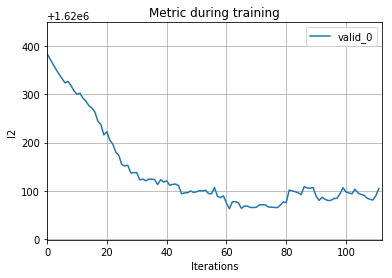

In [116]:
ax = lgb.plot_metric(evals_result, metric='l2')
plt.savefig('figures/gold_lgb_training.eps')

Predictions/Actual volatility correlation:  0.08081042392908386
Returns  59.16 %
Number of trades:  86
Number of short trades:  48
Number of long trades:  38
Earnings per trade:  68.79
Earnings per short trade:  97.35
Earnings per long trade:  32.71
Precision score:  [0.52083333 0.02409639 0.5       ]


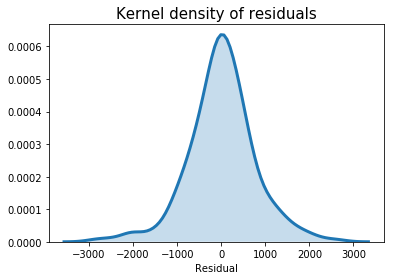

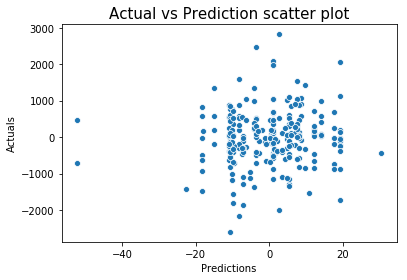

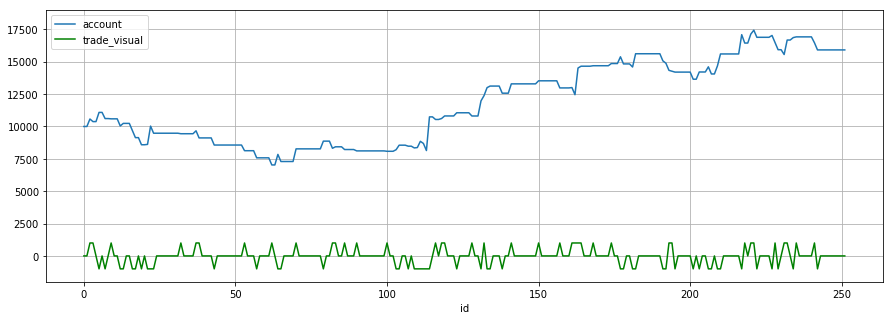

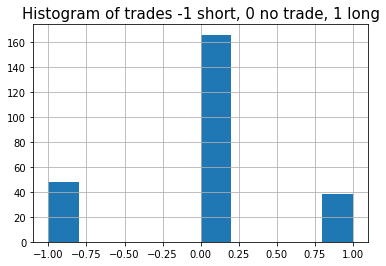

In [137]:
gold_account = get_performance(gold_clf, gold_reg_pca, gold_gains.loc[gold_gains.index > validate_date], gold_reg_validate, gold_reg_label_validate, stop_loss_long=1000, stop_loss_short=800, regression=True, target=10, name='gold_lgb')

In [119]:
X = pca_transform(corn_reg_train, corn_reg_pca)
y = corn_reg_label_train
train_data = lgb.Dataset(X, label=y)
X_test = pca_transform(corn_reg_test, corn_reg_pca)
y_test = corn_reg_label_test
test_data = lgb.Dataset(X_test, label=y_test)

evals_result = {}
corn_clf = lgb.train(param, train_data, num_round,
                     early_stopping_rounds=100,
                     valid_sets=[test_data], evals_result=evals_result)

[1]	valid_0's l2: 175904
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 175905
[3]	valid_0's l2: 175907
[4]	valid_0's l2: 175908
[5]	valid_0's l2: 175900
[6]	valid_0's l2: 175902
[7]	valid_0's l2: 175894
[8]	valid_0's l2: 175893
[9]	valid_0's l2: 175895
[10]	valid_0's l2: 175887
[11]	valid_0's l2: 175889
[12]	valid_0's l2: 175888
[13]	valid_0's l2: 175881
[14]	valid_0's l2: 175883
[15]	valid_0's l2: 175876
[16]	valid_0's l2: 175877
[17]	valid_0's l2: 175870
[18]	valid_0's l2: 175872
[19]	valid_0's l2: 175866
[20]	valid_0's l2: 175869
[21]	valid_0's l2: 175867
[22]	valid_0's l2: 175860
[23]	valid_0's l2: 175863
[24]	valid_0's l2: 175856
[25]	valid_0's l2: 175859
[26]	valid_0's l2: 175853
[27]	valid_0's l2: 175855
[28]	valid_0's l2: 175855
[29]	valid_0's l2: 175850
[30]	valid_0's l2: 175852
[31]	valid_0's l2: 175852
[32]	valid_0's l2: 175847
[33]	valid_0's l2: 175849
[34]	valid_0's l2: 175849
[35]	valid_0's l2: 175850
[36]	valid_0's l2: 175850
[37]	valid

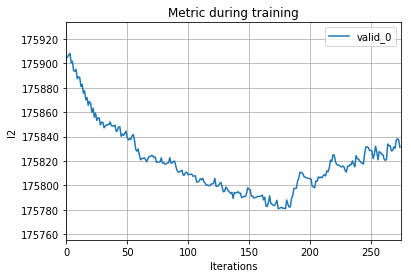

In [120]:
ax = lgb.plot_metric(evals_result, metric='l2')
plt.savefig('figures/corn_lgb_training.eps')

Predictions/Actual volatility correlation:  0.07818532914699987
Returns  5.14 %
Number of trades:  20
Number of short trades:  11
Number of long trades:  9
Earnings per trade:  25.70
Earnings per short trade:  44.92
Earnings per long trade:  2.21
Precision score:  [0.54545455 0.0387931  0.66666667]


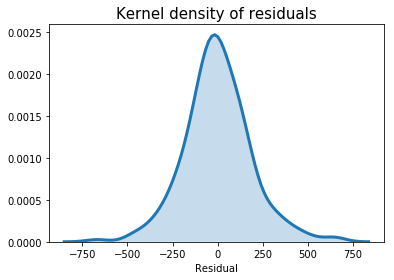

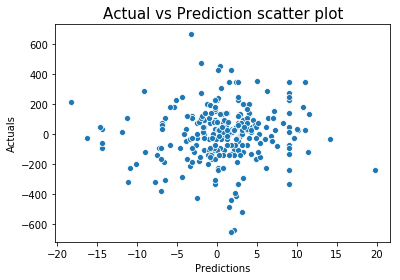

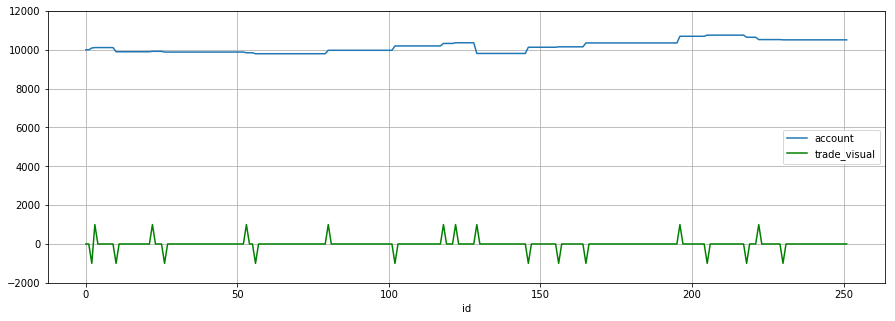

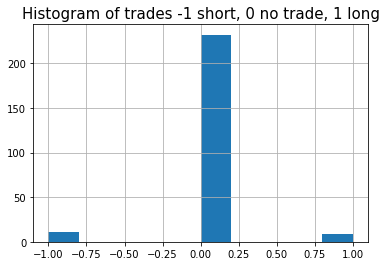

In [131]:
corn_account_lgb = get_performance(corn_clf, corn_reg_pca, corn_gains.loc[corn_gains.index > validate_date], corn_reg_validate, corn_reg_label_validate, stop_loss_long=300, stop_loss_short=300, regression=True, target=10, name='corn_lgb')

In [124]:
X = pca_transform(coffee_reg_train, coffee_reg_pca)
ln_train = len(X)
y = coffee_reg_label_train.values
train_data = lgb.Dataset(X, label=y)
X_test = pca_transform(coffee_reg_test, coffee_reg_pca)
ln_test = len(X_test)
y_test = coffee_reg_label_test.values
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

evals_result = {}
coffee_clf = lgb.train(param, train_data, num_round, early_stopping_rounds=100, valid_sets=[test_data], evals_result=evals_result)

[1]	valid_0's l2: 161691
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 161691
[3]	valid_0's l2: 161691
[4]	valid_0's l2: 161692
[5]	valid_0's l2: 161693
[6]	valid_0's l2: 161693
[7]	valid_0's l2: 161695
[8]	valid_0's l2: 161695
[9]	valid_0's l2: 161695
[10]	valid_0's l2: 161697
[11]	valid_0's l2: 161701
[12]	valid_0's l2: 161700
[13]	valid_0's l2: 161701
[14]	valid_0's l2: 161704
[15]	valid_0's l2: 161706
[16]	valid_0's l2: 161709
[17]	valid_0's l2: 161700
[18]	valid_0's l2: 161704
[19]	valid_0's l2: 161695
[20]	valid_0's l2: 161699
[21]	valid_0's l2: 161698
[22]	valid_0's l2: 161690
[23]	valid_0's l2: 161694
[24]	valid_0's l2: 161685
[25]	valid_0's l2: 161690
[26]	valid_0's l2: 161692
[27]	valid_0's l2: 161686
[28]	valid_0's l2: 161684
[29]	valid_0's l2: 161685
[30]	valid_0's l2: 161679
[31]	valid_0's l2: 161679
[32]	valid_0's l2: 161685
[33]	valid_0's l2: 161683
[34]	valid_0's l2: 161683
[35]	valid_0's l2: 161683
[36]	valid_0's l2: 161684
[37]	valid

[366]	valid_0's l2: 161414
[367]	valid_0's l2: 161415
[368]	valid_0's l2: 161412
[369]	valid_0's l2: 161414
[370]	valid_0's l2: 161421
[371]	valid_0's l2: 161422
[372]	valid_0's l2: 161427
[373]	valid_0's l2: 161418
[374]	valid_0's l2: 161411
[375]	valid_0's l2: 161417
[376]	valid_0's l2: 161418
[377]	valid_0's l2: 161423
[378]	valid_0's l2: 161422
[379]	valid_0's l2: 161423
[380]	valid_0's l2: 161417
[381]	valid_0's l2: 161419
[382]	valid_0's l2: 161419
[383]	valid_0's l2: 161417
[384]	valid_0's l2: 161423
[385]	valid_0's l2: 161423
[386]	valid_0's l2: 161428
[387]	valid_0's l2: 161433
[388]	valid_0's l2: 161437
[389]	valid_0's l2: 161431
[390]	valid_0's l2: 161438
[391]	valid_0's l2: 161439
[392]	valid_0's l2: 161431
[393]	valid_0's l2: 161435
[394]	valid_0's l2: 161442
[395]	valid_0's l2: 161435
[396]	valid_0's l2: 161436
[397]	valid_0's l2: 161440
[398]	valid_0's l2: 161447
[399]	valid_0's l2: 161441
[400]	valid_0's l2: 161448
[401]	valid_0's l2: 161448
[402]	valid_0's l2: 161454
[

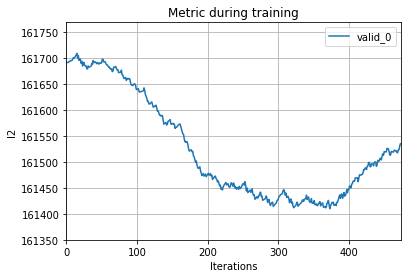

In [125]:
ax = lgb.plot_metric(evals_result, metric='l2')
plt.savefig('figures/coffee_lgb_training.eps')

Predictions/Actual volatility correlation:  -0.0014039801132773953
Returns  62.54 %
Number of trades:  37
Number of short trades:  24
Number of long trades:  13
Earnings per trade:  169.04
Earnings per short trade:  216.42
Earnings per long trade:  81.56
Precision score:  [0.45833333 0.03255814 0.23076923]


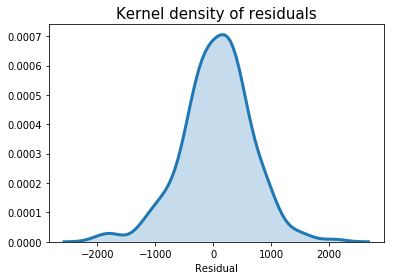

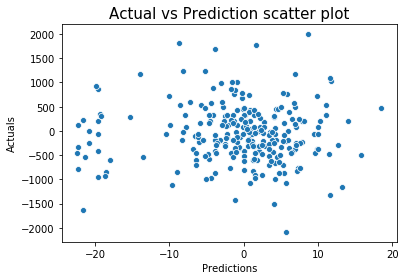

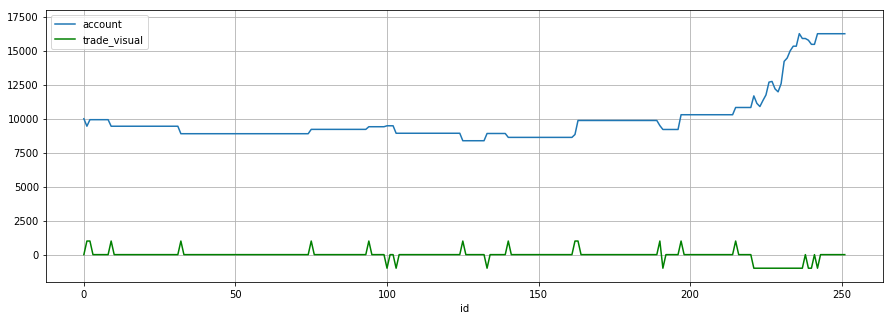

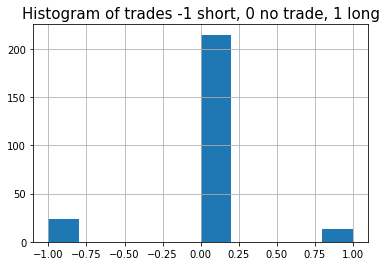

In [138]:
coffee_account_lgb = get_performance(coffee_clf, coffee_reg_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_reg_validate, coffee_reg_label_validate, stop_loss_long=1000, stop_loss_short=1000, regression=True, target=10, name='coffee_lgb')

# Neural Networks classifier
---


| commodity | gains % | earnings per trade | number of trades |
|-----------|---------|--------------------|------------------|
| gold      | 125     | 73.17              | 172              |
| corn      | 7       | 5.2                | 141              |
| coffee    | -100    | -90.6              | 111              |

In [166]:
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/


def plot_training_history_acc(history, name):
    # history = model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, verbose=0)
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.show()
    plt.savefig('figures/' + name + '_keras_accuracy.eps')
    
    
def plot_training_history_loss(history, name):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('figures/' + name + '_keras_loss.eps')
    # plt.show()

In [179]:
history.history['loss'][-10:]

[183326.309353918,
 190581.03005400233,
 181068.55817413726,
 178127.65173966982,
 181871.14612253502,
 182052.30410166385,
 180558.40369988972,
 183861.07331668396,
 180493.04715474183,
 181308.34317429943]

In [180]:
history.history['val_loss'][-10:]

[185968.0473269628,
 176198.19770144628,
 179855.78095945247,
 177653.49449573865,
 174530.6609956095,
 176566.82189436984,
 200360.24728822315,
 194085.51336518594,
 181381.8858793905,
 187372.24018595042]

In [155]:
def create_target(x):
    if x == 1.0:
        return [0,0,1]
    elif x == 0.0:
        return [1,0,0]
    else:
        return [0,1,0]

In [156]:
X = pca_transform(gold_train, gold_pca)
y = gold_label_train
# remove outliers
X, y = remove_outliers(X, y, out_gold)

X_test = pca_transform(gold_test, gold_pca)
y_test = gold_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_gold)
y = np.array(list(map(create_target, y)))
y_test = np.array(list(map(create_target, y_test)))

# X = np.concatenate([X, X_test])
# y = np.concatenate([y, y_test])

In [188]:
# %%capture training_gold
from keras.layers import Dropout, Flatten, Dense, Activation, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam
from keras.models import Sequential
from keras.metrics import categorical_accuracy, binary_accuracy, sparse_categorical_accuracy
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import RMSprop

input_shape = 200
num_classes = 3

def define_model(input_shape, num_classes):
    # Define a model
    opt = RMSprop(lr=0.0001)
    
    model = Sequential()  
    model.add(Dense(32, input_dim=input_shape, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Dense(8, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    model.add(Dense(num_classes))
    model.add(Activation('tanh'))

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# opt = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
# opt = Nadam(lr=0.002)
batch_size = 20
epochs = 500
model = define_model(input_shape, num_classes)

In [189]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.gold.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

In [190]:
# model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X, y,
                    validation_data=(X_test, y_test),
                    # validation_split=0.2,
                    batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

model.summary()

Train on 1927 samples, validate on 484 samples
Epoch 1/500
1927/1927 [==============================] - 2s 780us/step - loss: 71676344797.1936 - acc: 0.3181 - val_loss: 68907328935.1405 - val_acc: 0.3244

Epoch 00001: val_loss improved from inf to 68907328935.14050, saving model to saved_models/weights.gold.hdf5
Epoch 2/500
1927/1927 [==============================] - 0s 213us/step - loss: 65611146702.8459 - acc: 0.3378 - val_loss: 62976963694.0165 - val_acc: 0.3202

Epoch 00002: val_loss improved from 68907328935.14050 to 62976963694.01653, saving model to saved_models/weights.gold.hdf5
Epoch 3/500
1927/1927 [==============================] - 0s 211us/step - loss: 59984190554.8687 - acc: 0.3404 - val_loss: 57451244408.5950 - val_acc: 0.3140

Epoch 00003: val_loss improved from 62976963694.01653 to 57451244408.59504, saving model to saved_models/weights.gold.hdf5
Epoch 4/500
1927/1927 [==============================] - 0s 223us/step - loss: 54720632714.0301 - acc: 0.3363 - val_loss: 52

1927/1927 [==============================] - 0s 208us/step - loss: 2196838786.2252 - acc: 0.3409 - val_loss: 1907274976.5289 - val_acc: 0.3388

Epoch 00030: val_loss improved from 2356912594.51240 to 1907274976.52893, saving model to saved_models/weights.gold.hdf5
Epoch 31/500
1927/1927 [==============================] - 0s 201us/step - loss: 1765217499.8983 - acc: 0.3404 - val_loss: 1514495052.6942 - val_acc: 0.3347

Epoch 00031: val_loss improved from 1907274976.52893 to 1514495052.69421, saving model to saved_models/weights.gold.hdf5
Epoch 32/500
1927/1927 [==============================] - 0s 200us/step - loss: 1385995174.6923 - acc: 0.3306 - val_loss: 1172316041.7851 - val_acc: 0.3388

Epoch 00032: val_loss improved from 1514495052.69421 to 1172316041.78512, saving model to saved_models/weights.gold.hdf5
Epoch 33/500
1927/1927 [==============================] - 0s 243us/step - loss: 1062198631.9543 - acc: 0.3472 - val_loss: 881289239.2727 - val_acc: 0.3285

Epoch 00033: val_loss i

1927/1927 [==============================] - 0s 209us/step - loss: 185210.6267 - acc: 0.3249 - val_loss: 193201.1925 - val_acc: 0.3409

Epoch 00064: val_loss did not improve from 159026.95309
Epoch 65/500
1927/1927 [==============================] - 0s 220us/step - loss: 179944.7821 - acc: 0.3212 - val_loss: 197219.7137 - val_acc: 0.3554

Epoch 00065: val_loss did not improve from 159026.95309
Epoch 66/500
1927/1927 [==============================] - 0s 212us/step - loss: 183355.8535 - acc: 0.3160 - val_loss: 173509.5891 - val_acc: 0.2955

Epoch 00066: val_loss did not improve from 159026.95309
Epoch 67/500
1927/1927 [==============================] - 0s 211us/step - loss: 180491.7916 - acc: 0.3420 - val_loss: 222581.1332 - val_acc: 0.2913

Epoch 00067: val_loss did not improve from 159026.95309
Epoch 68/500
1927/1927 [==============================] - 0s 210us/step - loss: 182369.7082 - acc: 0.3342 - val_loss: 179867.6584 - val_acc: 0.3058

Epoch 00068: val_loss did not improve from 1

1927/1927 [==============================] - 0s 226us/step - loss: 182040.0980 - acc: 0.3228 - val_loss: 159908.0195 - val_acc: 0.3161

Epoch 00104: val_loss did not improve from 148725.55522
Epoch 105/500
1927/1927 [==============================] - 0s 226us/step - loss: 183985.2770 - acc: 0.3166 - val_loss: 192307.8419 - val_acc: 0.3264

Epoch 00105: val_loss did not improve from 148725.55522
Epoch 106/500
1927/1927 [==============================] - 0s 218us/step - loss: 182744.9619 - acc: 0.3378 - val_loss: 176794.5497 - val_acc: 0.3409

Epoch 00106: val_loss did not improve from 148725.55522
Epoch 107/500
1927/1927 [==============================] - 0s 215us/step - loss: 180447.5033 - acc: 0.3394 - val_loss: 178410.7025 - val_acc: 0.3450

Epoch 00107: val_loss did not improve from 148725.55522
Epoch 108/500
1927/1927 [==============================] - 0s 220us/step - loss: 183916.4222 - acc: 0.3316 - val_loss: 176329.7827 - val_acc: 0.2996

Epoch 00108: val_loss did not improve fr

1927/1927 [==============================] - 0s 214us/step - loss: 178629.0535 - acc: 0.3420 - val_loss: 194793.9992 - val_acc: 0.3037

Epoch 00144: val_loss did not improve from 148725.55522
Epoch 145/500
1927/1927 [==============================] - 0s 216us/step - loss: 184482.8843 - acc: 0.3197 - val_loss: 164123.2966 - val_acc: 0.3430

Epoch 00145: val_loss did not improve from 148725.55522
Epoch 146/500
1927/1927 [==============================] - 0s 213us/step - loss: 181021.2215 - acc: 0.3306 - val_loss: 173575.8541 - val_acc: 0.3306

Epoch 00146: val_loss did not improve from 148725.55522
Epoch 147/500
1927/1927 [==============================] - 0s 215us/step - loss: 181801.2051 - acc: 0.3352 - val_loss: 175912.5673 - val_acc: 0.3017

Epoch 00147: val_loss did not improve from 148725.55522
Epoch 148/500
1927/1927 [==============================] - 0s 225us/step - loss: 180899.4189 - acc: 0.3207 - val_loss: 173640.4926 - val_acc: 0.3161

Epoch 00148: val_loss did not improve fr

1927/1927 [==============================] - 0s 220us/step - loss: 185655.1979 - acc: 0.3129 - val_loss: 162715.6533 - val_acc: 0.2665

Epoch 00184: val_loss did not improve from 148725.55522
Epoch 185/500
1927/1927 [==============================] - 0s 220us/step - loss: 181524.9333 - acc: 0.3275 - val_loss: 194859.8896 - val_acc: 0.3017

Epoch 00185: val_loss did not improve from 148725.55522
Epoch 186/500
1927/1927 [==============================] - 0s 219us/step - loss: 186253.2492 - acc: 0.3326 - val_loss: 178090.5098 - val_acc: 0.2975

Epoch 00186: val_loss did not improve from 148725.55522
Epoch 187/500
1927/1927 [==============================] - 0s 218us/step - loss: 181624.4123 - acc: 0.3191 - val_loss: 178859.5973 - val_acc: 0.3120

Epoch 00187: val_loss did not improve from 148725.55522
Epoch 188/500
1927/1927 [==============================] - 0s 212us/step - loss: 179395.7147 - acc: 0.3363 - val_loss: 193134.6966 - val_acc: 0.2975

Epoch 00188: val_loss did not improve fr

1927/1927 [==============================] - 0s 212us/step - loss: 182893.0361 - acc: 0.3358 - val_loss: 196503.6555 - val_acc: 0.2831

Epoch 00224: val_loss did not improve from 148725.55522
Epoch 225/500
1927/1927 [==============================] - 0s 224us/step - loss: 181936.2657 - acc: 0.3181 - val_loss: 164975.3480 - val_acc: 0.3140

Epoch 00225: val_loss did not improve from 148725.55522
Epoch 226/500
1927/1927 [==============================] - 0s 217us/step - loss: 182909.1966 - acc: 0.3311 - val_loss: 171540.0141 - val_acc: 0.3161

Epoch 00226: val_loss did not improve from 148725.55522
Epoch 227/500
1927/1927 [==============================] - 0s 214us/step - loss: 183544.2071 - acc: 0.3197 - val_loss: 166363.6252 - val_acc: 0.3471

Epoch 00227: val_loss did not improve from 148725.55522
Epoch 228/500
1927/1927 [==============================] - 0s 218us/step - loss: 180330.8674 - acc: 0.3409 - val_loss: 188284.4159 - val_acc: 0.3140

Epoch 00228: val_loss did not improve fr


Epoch 00263: val_loss did not improve from 140647.67094
Epoch 264/500
1927/1927 [==============================] - 0s 219us/step - loss: 179509.6092 - acc: 0.3290 - val_loss: 168236.0197 - val_acc: 0.2893

Epoch 00264: val_loss did not improve from 140647.67094
Epoch 265/500
1927/1927 [==============================] - 0s 217us/step - loss: 182007.4519 - acc: 0.3134 - val_loss: 193944.0774 - val_acc: 0.3099

Epoch 00265: val_loss did not improve from 140647.67094
Epoch 266/500
1927/1927 [==============================] - 0s 218us/step - loss: 181702.5127 - acc: 0.3342 - val_loss: 219921.4823 - val_acc: 0.3264

Epoch 00266: val_loss did not improve from 140647.67094
Epoch 267/500
1927/1927 [==============================] - 0s 212us/step - loss: 186045.7713 - acc: 0.3269 - val_loss: 186717.5546 - val_acc: 0.3368

Epoch 00267: val_loss did not improve from 140647.67094
Epoch 268/500
1927/1927 [==============================] - 0s 212us/step - loss: 180770.5643 - acc: 0.3212 - val_loss: 


Epoch 00303: val_loss did not improve from 140647.67094
Epoch 304/500
1927/1927 [==============================] - 0s 218us/step - loss: 178633.0963 - acc: 0.3088 - val_loss: 194298.3044 - val_acc: 0.2789

Epoch 00304: val_loss did not improve from 140647.67094
Epoch 305/500
1927/1927 [==============================] - 0s 214us/step - loss: 184016.4032 - acc: 0.3217 - val_loss: 188657.9752 - val_acc: 0.2769

Epoch 00305: val_loss did not improve from 140647.67094
Epoch 306/500
1927/1927 [==============================] - 0s 219us/step - loss: 181070.6171 - acc: 0.3217 - val_loss: 185893.8601 - val_acc: 0.2934

Epoch 00306: val_loss did not improve from 140647.67094
Epoch 307/500
1927/1927 [==============================] - 0s 217us/step - loss: 181927.3402 - acc: 0.3368 - val_loss: 174952.6044 - val_acc: 0.3182

Epoch 00307: val_loss did not improve from 140647.67094
Epoch 308/500
1927/1927 [==============================] - 0s 219us/step - loss: 184691.0853 - acc: 0.3233 - val_loss: 


Epoch 00343: val_loss did not improve from 140647.67094
Epoch 344/500
1927/1927 [==============================] - 0s 224us/step - loss: 184569.7648 - acc: 0.3290 - val_loss: 168159.8583 - val_acc: 0.3202

Epoch 00344: val_loss did not improve from 140647.67094
Epoch 345/500
1927/1927 [==============================] - 0s 218us/step - loss: 180358.2056 - acc: 0.3233 - val_loss: 196830.1962 - val_acc: 0.3017

Epoch 00345: val_loss did not improve from 140647.67094
Epoch 346/500
1927/1927 [==============================] - 0s 220us/step - loss: 183297.6336 - acc: 0.3155 - val_loss: 170290.3235 - val_acc: 0.3223

Epoch 00346: val_loss did not improve from 140647.67094
Epoch 347/500
1927/1927 [==============================] - 0s 224us/step - loss: 180264.1383 - acc: 0.3259 - val_loss: 184131.2882 - val_acc: 0.3202

Epoch 00347: val_loss did not improve from 140647.67094
Epoch 348/500
1927/1927 [==============================] - 0s 222us/step - loss: 184951.7873 - acc: 0.3503 - val_loss: 


Epoch 00383: val_loss did not improve from 140647.67094
Epoch 384/500
1927/1927 [==============================] - 0s 228us/step - loss: 186396.6284 - acc: 0.3134 - val_loss: 198621.1200 - val_acc: 0.3120

Epoch 00384: val_loss did not improve from 140647.67094
Epoch 385/500
1927/1927 [==============================] - 0s 220us/step - loss: 181607.7501 - acc: 0.3228 - val_loss: 187114.1629 - val_acc: 0.3409

Epoch 00385: val_loss did not improve from 140647.67094
Epoch 386/500
1927/1927 [==============================] - 0s 215us/step - loss: 181127.7145 - acc: 0.3368 - val_loss: 182622.4751 - val_acc: 0.3140

Epoch 00386: val_loss did not improve from 140647.67094
Epoch 387/500
1927/1927 [==============================] - 0s 223us/step - loss: 183234.0851 - acc: 0.3389 - val_loss: 183642.1575 - val_acc: 0.3306

Epoch 00387: val_loss did not improve from 140647.67094
Epoch 388/500
1927/1927 [==============================] - 0s 219us/step - loss: 183032.7939 - acc: 0.3394 - val_loss: 


Epoch 00423: val_loss did not improve from 140647.67094
Epoch 424/500
1927/1927 [==============================] - 0s 212us/step - loss: 180444.1951 - acc: 0.3373 - val_loss: 184927.1825 - val_acc: 0.3161

Epoch 00424: val_loss did not improve from 140647.67094
Epoch 425/500
1927/1927 [==============================] - 0s 217us/step - loss: 182364.9639 - acc: 0.3145 - val_loss: 215543.3733 - val_acc: 0.3285

Epoch 00425: val_loss did not improve from 140647.67094
Epoch 426/500
1927/1927 [==============================] - 0s 227us/step - loss: 183732.8376 - acc: 0.3254 - val_loss: 176241.7816 - val_acc: 0.3306

Epoch 00426: val_loss did not improve from 140647.67094
Epoch 427/500
1927/1927 [==============================] - 0s 220us/step - loss: 184004.9945 - acc: 0.3186 - val_loss: 194282.4466 - val_acc: 0.3285

Epoch 00427: val_loss did not improve from 140647.67094
Epoch 428/500
1927/1927 [==============================] - 0s 223us/step - loss: 183650.5490 - acc: 0.3275 - val_loss: 


Epoch 00463: val_loss did not improve from 140647.67094
Epoch 464/500
1927/1927 [==============================] - 0s 217us/step - loss: 181802.2566 - acc: 0.3285 - val_loss: 180258.7481 - val_acc: 0.3512

Epoch 00464: val_loss did not improve from 140647.67094
Epoch 465/500
1927/1927 [==============================] - 0s 216us/step - loss: 184378.9609 - acc: 0.3342 - val_loss: 177327.0812 - val_acc: 0.3161

Epoch 00465: val_loss did not improve from 140647.67094
Epoch 466/500
1927/1927 [==============================] - 0s 222us/step - loss: 181616.7330 - acc: 0.3347 - val_loss: 171889.1523 - val_acc: 0.3264

Epoch 00466: val_loss did not improve from 140647.67094
Epoch 467/500
1927/1927 [==============================] - 0s 225us/step - loss: 181666.3968 - acc: 0.3430 - val_loss: 181759.9890 - val_acc: 0.3017

Epoch 00467: val_loss did not improve from 140647.67094
Epoch 468/500
1927/1927 [==============================] - 0s 213us/step - loss: 184326.3709 - acc: 0.3212 - val_loss: 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


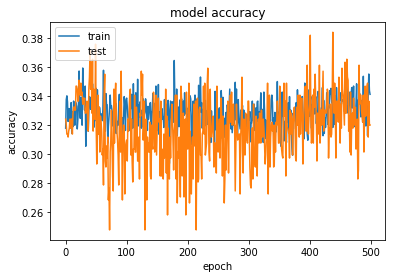

In [191]:
plot_training_history_acc(history, 'gold_nn_clf')

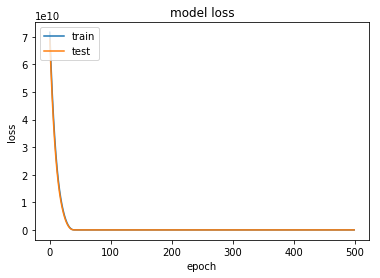

In [192]:
plot_training_history_loss(history, 'gold_nn_clf')

In [193]:
model.load_weights('saved_models/weights.gold.hdf5')
gold_clf_nn = model

Returns  204.30 %
Number of trades:  178
Number of short trades:  91
Number of long trades:  87
Earnings per trade:  114.77
Earnings per short trade:  136.99
Earnings per long trade:  91.53
Precision score:  [0.26373626 0.66216216 0.24137931]


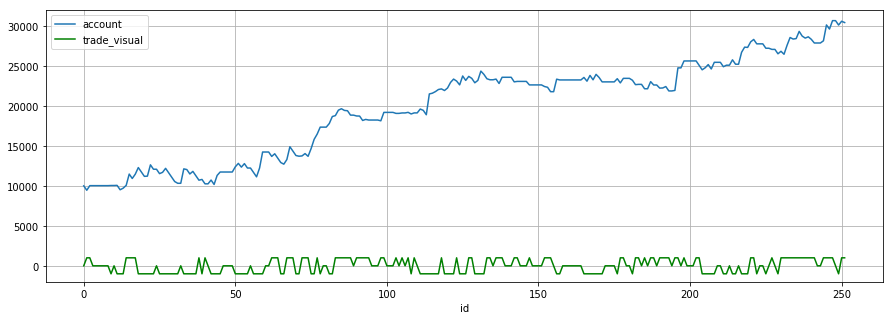

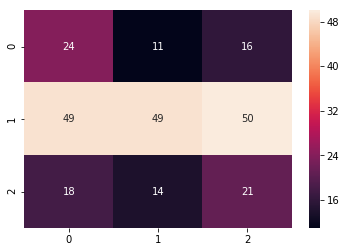

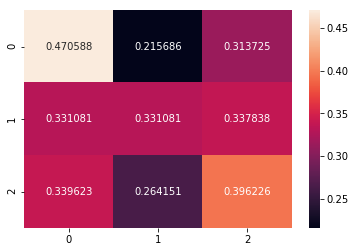

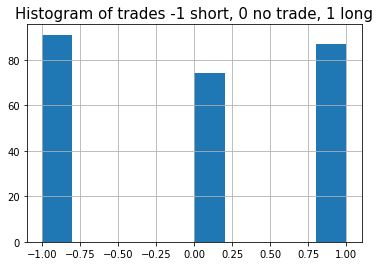

In [194]:
gold_account_nn = get_performance(gold_clf_nn, gold_pca, gold_gains.loc[gold_gains.index > validate_date], gold_validate, gold_label_validate, stop_loss_long=1000, stop_loss_short=800, name='gold_nn_cls', regression=False)

In [195]:
X = pca_transform(corn_train, corn_pca)
y = corn_label_train
# remove outliers
X, y = remove_outliers(X, y, out_corn)

X_test = pca_transform(corn_test, corn_pca)
y_test = corn_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_corn)
y = np.array(list(map(create_target, y)))
y_test = np.array(list(map(create_target, y_test)))

model = define_model(input_shape, num_classes)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.corn.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

history = model.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

model.summary()
model.load_weights('saved_models/weights.corn.hdf5')
corn_clf_nn = model

Train on 1928 samples, validate on 483 samples
Epoch 1/500
1928/1928 [==============================] - 2s 909us/step - loss: 64740754572.2158 - acc: 0.3107 - val_loss: 61899975128.7785 - val_acc: 0.3147

Epoch 00001: val_loss improved from inf to 61899975128.77847, saving model to saved_models/weights.corn.hdf5
Epoch 2/500
1928/1928 [==============================] - 0s 214us/step - loss: 58765825223.7012 - acc: 0.3102 - val_loss: 56166121942.6584 - val_acc: 0.3126

Epoch 00002: val_loss improved from 61899975128.77847 to 56166121942.65839, saving model to saved_models/weights.corn.hdf5
Epoch 3/500
1928/1928 [==============================] - 0s 219us/step - loss: 53267454189.9419 - acc: 0.3299 - val_loss: 50903913981.8799 - val_acc: 0.3209

Epoch 00003: val_loss improved from 56166121942.65839 to 50903913981.87992, saving model to saved_models/weights.corn.hdf5
Epoch 4/500
1928/1928 [==============================] - 0s 218us/step - loss: 48189223974.2407 - acc: 0.3371 - val_loss: 46

1928/1928 [==============================] - 0s 223us/step - loss: 1947713216.5311 - acc: 0.3361 - val_loss: 1751761908.1408 - val_acc: 0.3251

Epoch 00030: val_loss improved from 2127353576.08282 to 1751761908.14079, saving model to saved_models/weights.corn.hdf5
Epoch 31/500
1928/1928 [==============================] - 0s 220us/step - loss: 1595721948.6805 - acc: 0.3221 - val_loss: 1421270930.4182 - val_acc: 0.3271

Epoch 00031: val_loss improved from 1751761908.14079 to 1421270930.41822, saving model to saved_models/weights.corn.hdf5
Epoch 32/500
1928/1928 [==============================] - 0s 214us/step - loss: 1281597133.1452 - acc: 0.3278 - val_loss: 1127437210.4679 - val_acc: 0.3188

Epoch 00032: val_loss improved from 1421270930.41822 to 1127437210.46791, saving model to saved_models/weights.corn.hdf5
Epoch 33/500
1928/1928 [==============================] - 0s 218us/step - loss: 1008691932.0166 - acc: 0.3226 - val_loss: 874527340.8199 - val_acc: 0.3064

Epoch 00033: val_loss i


Epoch 00063: val_loss did not improve from 137895.40505
Epoch 64/500
1928/1928 [==============================] - 0s 215us/step - loss: 159358.2617 - acc: 0.3449 - val_loss: 156141.1140 - val_acc: 0.3147

Epoch 00064: val_loss did not improve from 137895.40505
Epoch 65/500
1928/1928 [==============================] - 0s 225us/step - loss: 152306.8579 - acc: 0.3345 - val_loss: 153477.6921 - val_acc: 0.3230

Epoch 00065: val_loss did not improve from 137895.40505
Epoch 66/500
1928/1928 [==============================] - 0s 220us/step - loss: 161141.7686 - acc: 0.3304 - val_loss: 144644.9901 - val_acc: 0.3168

Epoch 00066: val_loss did not improve from 137895.40505
Epoch 67/500
1928/1928 [==============================] - 0s 217us/step - loss: 154265.0889 - acc: 0.3325 - val_loss: 165210.9935 - val_acc: 0.3354

Epoch 00067: val_loss did not improve from 137895.40505
Epoch 68/500
1928/1928 [==============================] - 0s 216us/step - loss: 156807.5338 - acc: 0.3112 - val_loss: 19131

1928/1928 [==============================] - 0s 220us/step - loss: 158438.3007 - acc: 0.3247 - val_loss: 161268.0214 - val_acc: 0.2961

Epoch 00103: val_loss did not improve from 127158.71768
Epoch 104/500
1928/1928 [==============================] - 0s 218us/step - loss: 155516.0200 - acc: 0.3330 - val_loss: 136815.3726 - val_acc: 0.3333

Epoch 00104: val_loss did not improve from 127158.71768
Epoch 105/500
1928/1928 [==============================] - 0s 219us/step - loss: 157532.0692 - acc: 0.3185 - val_loss: 165257.7675 - val_acc: 0.3188

Epoch 00105: val_loss did not improve from 127158.71768
Epoch 106/500
1928/1928 [==============================] - 0s 218us/step - loss: 153783.2613 - acc: 0.3086 - val_loss: 164596.4600 - val_acc: 0.3271

Epoch 00106: val_loss did not improve from 127158.71768
Epoch 107/500
1928/1928 [==============================] - 0s 214us/step - loss: 160516.4097 - acc: 0.3237 - val_loss: 145746.2535 - val_acc: 0.2981

Epoch 00107: val_loss did not improve fr

1928/1928 [==============================] - 0s 216us/step - loss: 155783.1143 - acc: 0.3133 - val_loss: 162640.2854 - val_acc: 0.3665

Epoch 00143: val_loss did not improve from 127158.71768
Epoch 144/500
1928/1928 [==============================] - 0s 218us/step - loss: 155322.4705 - acc: 0.3091 - val_loss: 159361.4808 - val_acc: 0.3043

Epoch 00144: val_loss did not improve from 127158.71768
Epoch 145/500
1928/1928 [==============================] - 0s 218us/step - loss: 156914.0600 - acc: 0.3283 - val_loss: 174216.2784 - val_acc: 0.3333

Epoch 00145: val_loss did not improve from 127158.71768
Epoch 146/500
1928/1928 [==============================] - 0s 218us/step - loss: 153530.9387 - acc: 0.3361 - val_loss: 159095.0986 - val_acc: 0.2961

Epoch 00146: val_loss did not improve from 127158.71768
Epoch 147/500
1928/1928 [==============================] - 0s 224us/step - loss: 157700.2039 - acc: 0.3237 - val_loss: 141779.7409 - val_acc: 0.2836

Epoch 00147: val_loss did not improve fr

1928/1928 [==============================] - 0s 217us/step - loss: 156079.7532 - acc: 0.3237 - val_loss: 153241.8470 - val_acc: 0.3333

Epoch 00183: val_loss did not improve from 127158.71768
Epoch 184/500
1928/1928 [==============================] - 0s 219us/step - loss: 156719.9916 - acc: 0.3402 - val_loss: 153053.8281 - val_acc: 0.3064

Epoch 00184: val_loss did not improve from 127158.71768
Epoch 185/500
1928/1928 [==============================] - 0s 217us/step - loss: 155903.8621 - acc: 0.3273 - val_loss: 151474.9140 - val_acc: 0.3064

Epoch 00185: val_loss did not improve from 127158.71768
Epoch 186/500
1928/1928 [==============================] - 0s 217us/step - loss: 155437.4779 - acc: 0.3294 - val_loss: 165764.6076 - val_acc: 0.3416

Epoch 00186: val_loss did not improve from 127158.71768
Epoch 187/500
1928/1928 [==============================] - 0s 220us/step - loss: 156132.6014 - acc: 0.3237 - val_loss: 177757.7147 - val_acc: 0.2940

Epoch 00187: val_loss did not improve fr

1928/1928 [==============================] - 0s 213us/step - loss: 158259.9211 - acc: 0.3345 - val_loss: 132196.5405 - val_acc: 0.3458

Epoch 00223: val_loss did not improve from 127158.71768
Epoch 224/500
1928/1928 [==============================] - 0s 224us/step - loss: 158252.0563 - acc: 0.3340 - val_loss: 149459.8662 - val_acc: 0.3126

Epoch 00224: val_loss did not improve from 127158.71768
Epoch 225/500
1928/1928 [==============================] - 0s 219us/step - loss: 153323.9590 - acc: 0.3408 - val_loss: 180345.8585 - val_acc: 0.3395

Epoch 00225: val_loss did not improve from 127158.71768
Epoch 226/500
1928/1928 [==============================] - 0s 217us/step - loss: 160466.6015 - acc: 0.3257 - val_loss: 158719.2722 - val_acc: 0.3333

Epoch 00226: val_loss did not improve from 127158.71768
Epoch 227/500
1928/1928 [==============================] - 0s 218us/step - loss: 157436.0159 - acc: 0.3314 - val_loss: 147412.3839 - val_acc: 0.3416

Epoch 00227: val_loss did not improve fr

1928/1928 [==============================] - 0s 222us/step - loss: 153636.8289 - acc: 0.3589 - val_loss: 161774.8263 - val_acc: 0.3230

Epoch 00263: val_loss did not improve from 127158.71768
Epoch 264/500
1928/1928 [==============================] - 0s 215us/step - loss: 156906.6304 - acc: 0.3294 - val_loss: 167374.8869 - val_acc: 0.3002

Epoch 00264: val_loss did not improve from 127158.71768
Epoch 265/500
1928/1928 [==============================] - 0s 214us/step - loss: 154087.5133 - acc: 0.3268 - val_loss: 145254.4000 - val_acc: 0.3188

Epoch 00265: val_loss did not improve from 127158.71768
Epoch 266/500
1928/1928 [==============================] - 0s 216us/step - loss: 157854.9368 - acc: 0.3340 - val_loss: 148166.5904 - val_acc: 0.3375

Epoch 00266: val_loss did not improve from 127158.71768
Epoch 267/500
1928/1928 [==============================] - 0s 217us/step - loss: 155081.0492 - acc: 0.3185 - val_loss: 143405.4009 - val_acc: 0.3230

Epoch 00267: val_loss did not improve fr

1928/1928 [==============================] - 0s 212us/step - loss: 157147.8939 - acc: 0.3413 - val_loss: 154662.1604 - val_acc: 0.3085

Epoch 00303: val_loss did not improve from 127158.71768
Epoch 304/500
1928/1928 [==============================] - 0s 230us/step - loss: 152087.2846 - acc: 0.3325 - val_loss: 158371.2878 - val_acc: 0.3292

Epoch 00304: val_loss did not improve from 127158.71768
Epoch 305/500
1928/1928 [==============================] - 0s 199us/step - loss: 158732.6045 - acc: 0.3231 - val_loss: 164073.8060 - val_acc: 0.3375

Epoch 00305: val_loss did not improve from 127158.71768
Epoch 306/500
1928/1928 [==============================] - 0s 198us/step - loss: 152640.5823 - acc: 0.3454 - val_loss: 157799.6570 - val_acc: 0.3602

Epoch 00306: val_loss did not improve from 127158.71768
Epoch 307/500
1928/1928 [==============================] - 0s 202us/step - loss: 158980.2644 - acc: 0.3392 - val_loss: 161246.9846 - val_acc: 0.3354

Epoch 00307: val_loss did not improve fr

1928/1928 [==============================] - 0s 208us/step - loss: 159053.5638 - acc: 0.3371 - val_loss: 144281.6571 - val_acc: 0.3520

Epoch 00343: val_loss did not improve from 127158.71768
Epoch 344/500
1928/1928 [==============================] - 0s 218us/step - loss: 153195.1867 - acc: 0.3226 - val_loss: 160000.5548 - val_acc: 0.3333

Epoch 00344: val_loss did not improve from 127158.71768
Epoch 345/500
1928/1928 [==============================] - 0s 208us/step - loss: 158076.5076 - acc: 0.3361 - val_loss: 156510.5826 - val_acc: 0.2961

Epoch 00345: val_loss did not improve from 127158.71768
Epoch 346/500
1928/1928 [==============================] - 0s 202us/step - loss: 154200.4830 - acc: 0.3377 - val_loss: 150112.5943 - val_acc: 0.3147

Epoch 00346: val_loss did not improve from 127158.71768
Epoch 347/500
1928/1928 [==============================] - 1s 262us/step - loss: 156413.0144 - acc: 0.3273 - val_loss: 143206.7853 - val_acc: 0.3292

Epoch 00347: val_loss did not improve fr


Epoch 00382: val_loss did not improve from 111349.18867
Epoch 383/500
1928/1928 [==============================] - 0s 218us/step - loss: 156201.1794 - acc: 0.3434 - val_loss: 167455.1774 - val_acc: 0.3188

Epoch 00383: val_loss did not improve from 111349.18867
Epoch 384/500
1928/1928 [==============================] - 0s 216us/step - loss: 158717.5095 - acc: 0.3454 - val_loss: 162476.5344 - val_acc: 0.2981

Epoch 00384: val_loss did not improve from 111349.18867
Epoch 385/500
1928/1928 [==============================] - 0s 221us/step - loss: 154265.0975 - acc: 0.3356 - val_loss: 159379.1702 - val_acc: 0.3437

Epoch 00385: val_loss did not improve from 111349.18867
Epoch 386/500
1928/1928 [==============================] - 0s 216us/step - loss: 155657.2928 - acc: 0.3320 - val_loss: 157944.0131 - val_acc: 0.3747

Epoch 00386: val_loss did not improve from 111349.18867
Epoch 387/500
1928/1928 [==============================] - 0s 213us/step - loss: 157042.1217 - acc: 0.3102 - val_loss: 


Epoch 00422: val_loss did not improve from 111349.18867
Epoch 423/500
1928/1928 [==============================] - 0s 227us/step - loss: 156106.8218 - acc: 0.3221 - val_loss: 157873.9640 - val_acc: 0.2899

Epoch 00423: val_loss did not improve from 111349.18867
Epoch 424/500
1928/1928 [==============================] - 0s 217us/step - loss: 154056.5219 - acc: 0.3226 - val_loss: 159538.2486 - val_acc: 0.3043

Epoch 00424: val_loss did not improve from 111349.18867
Epoch 425/500
1928/1928 [==============================] - 0s 221us/step - loss: 158509.0076 - acc: 0.3117 - val_loss: 149225.8695 - val_acc: 0.3085

Epoch 00425: val_loss did not improve from 111349.18867
Epoch 426/500
1928/1928 [==============================] - 0s 215us/step - loss: 155104.7449 - acc: 0.3408 - val_loss: 169475.7738 - val_acc: 0.3271

Epoch 00426: val_loss did not improve from 111349.18867
Epoch 427/500
1928/1928 [==============================] - 0s 216us/step - loss: 158615.6597 - acc: 0.3242 - val_loss: 


Epoch 00462: val_loss did not improve from 111349.18867
Epoch 463/500
1928/1928 [==============================] - 0s 213us/step - loss: 157129.9955 - acc: 0.3231 - val_loss: 134871.8311 - val_acc: 0.3313

Epoch 00463: val_loss did not improve from 111349.18867
Epoch 464/500
1928/1928 [==============================] - 0s 223us/step - loss: 154827.0010 - acc: 0.3371 - val_loss: 147050.5144 - val_acc: 0.3437

Epoch 00464: val_loss did not improve from 111349.18867
Epoch 465/500
1928/1928 [==============================] - 0s 215us/step - loss: 156736.7696 - acc: 0.3039 - val_loss: 154713.1235 - val_acc: 0.3292

Epoch 00465: val_loss did not improve from 111349.18867
Epoch 466/500
1928/1928 [==============================] - 0s 217us/step - loss: 156663.2385 - acc: 0.3283 - val_loss: 158445.3402 - val_acc: 0.3437

Epoch 00466: val_loss did not improve from 111349.18867
Epoch 467/500
1928/1928 [==============================] - 0s 215us/step - loss: 157676.4139 - acc: 0.3361 - val_loss: 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


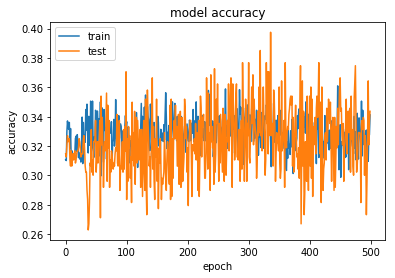

In [196]:
plot_training_history_acc(history, 'corn_nn_clf')

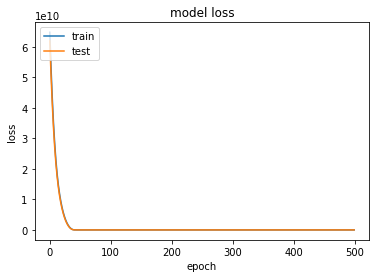

In [197]:
plot_training_history_loss(history, 'corn_nn_clf')

Returns  6.99 %
Number of trades:  146
Number of short trades:  94
Number of long trades:  52
Earnings per trade:  4.79
Earnings per short trade:  12.53
Earnings per long trade:  -9.21
Precision score:  [0.19148936 0.63207547 0.21153846]


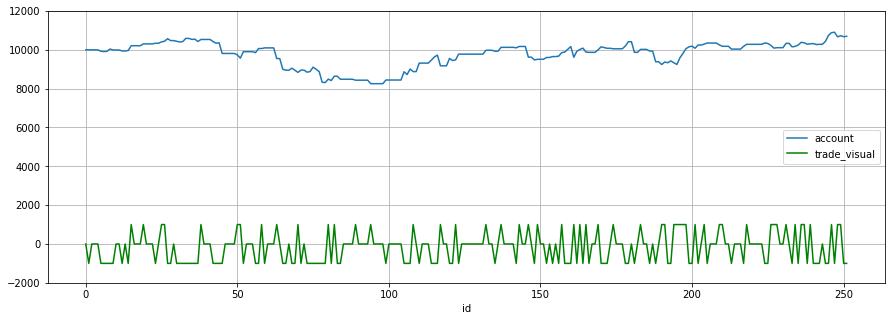

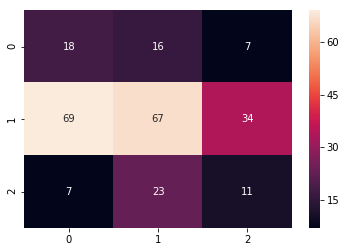

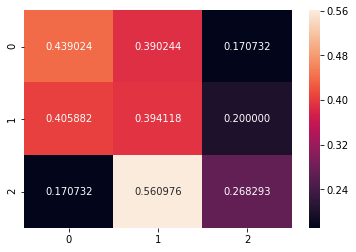

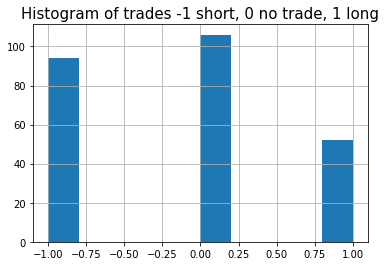

In [198]:
corn_account_nn = get_performance(corn_clf_nn, corn_pca, corn_gains.loc[corn_gains.index > validate_date], corn_validate, corn_label_validate, stop_loss_long=300, stop_loss_short=300, name='corn_nn_cls')

In [199]:
X = pca_transform(coffee_train, coffee_pca)
y = coffee_label_train
# remove outliers
X, y = remove_outliers(X, y, out_coffee)

X_test = pca_transform(coffee_test, coffee_pca)
y_test = coffee_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_coffee)
y = np.array(list(map(create_target, y)))
y_test = np.array(list(map(create_target, y_test)))

model = define_model(input_shape, num_classes)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.coffee.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

history = model.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

model.summary()
model.load_weights('saved_models/weights.coffee.hdf5')
coffee_clf_nn = model

Train on 1923 samples, validate on 481 samples
Epoch 1/500
1923/1923 [==============================] - 2s 995us/step - loss: 4405354192.4992 - acc: 0.3411 - val_loss: 4285960441.6133 - val_acc: 0.3347

Epoch 00001: val_loss improved from inf to 4285960441.61331, saving model to saved_models/weights.coffee.hdf5
Epoch 2/500
1923/1923 [==============================] - 0s 250us/step - loss: 4236877220.8092 - acc: 0.3328 - val_loss: 4133266368.6653 - val_acc: 0.3347

Epoch 00002: val_loss improved from 4285960441.61331 to 4133266368.66528, saving model to saved_models/weights.coffee.hdf5
Epoch 3/500
1923/1923 [==============================] - 0s 216us/step - loss: 4084563601.0400 - acc: 0.3219 - val_loss: 3987259683.3929 - val_acc: 0.3347

Epoch 00003: val_loss improved from 4133266368.66528 to 3987259683.39293, saving model to saved_models/weights.coffee.hdf5
Epoch 4/500
1923/1923 [==============================] - 0s 219us/step - loss: 3951582551.3510 - acc: 0.3203 - val_loss: 38453010

1923/1923 [==============================] - 0s 201us/step - loss: 1376698182.0250 - acc: 0.3094 - val_loss: 1322861780.1580 - val_acc: 0.3430

Epoch 00030: val_loss improved from 1390510319.96674 to 1322861780.15800, saving model to saved_models/weights.coffee.hdf5
Epoch 31/500
1923/1923 [==============================] - 0s 204us/step - loss: 1309322109.1388 - acc: 0.3344 - val_loss: 1257120240.8316 - val_acc: 0.3430

Epoch 00031: val_loss improved from 1322861780.15800 to 1257120240.83160, saving model to saved_models/weights.coffee.hdf5
Epoch 32/500
1923/1923 [==============================] - 0s 201us/step - loss: 1240055323.6568 - acc: 0.3307 - val_loss: 1193242588.9397 - val_acc: 0.3472

Epoch 00032: val_loss improved from 1257120240.83160 to 1193242588.93971, saving model to saved_models/weights.coffee.hdf5
Epoch 33/500
1923/1923 [==============================] - 0s 203us/step - loss: 1181267128.2839 - acc: 0.3183 - val_loss: 1131807524.9231 - val_acc: 0.3451

Epoch 00033: val

Epoch 60/500
1923/1923 [==============================] - 0s 202us/step - loss: 117568248.4139 - acc: 0.3188 - val_loss: 104494189.2474 - val_acc: 0.3472

Epoch 00060: val_loss improved from 121763912.22453 to 104494189.24740, saving model to saved_models/weights.coffee.hdf5
Epoch 61/500
1923/1923 [==============================] - 0s 211us/step - loss: 100564642.5439 - acc: 0.3245 - val_loss: 88469688.5780 - val_acc: 0.3514

Epoch 00061: val_loss improved from 104494189.24740 to 88469688.57796, saving model to saved_models/weights.coffee.hdf5
Epoch 62/500
1923/1923 [==============================] - 0s 205us/step - loss: 84938571.0380 - acc: 0.3203 - val_loss: 74027729.6923 - val_acc: 0.3472

Epoch 00062: val_loss improved from 88469688.57796 to 74027729.69231, saving model to saved_models/weights.coffee.hdf5
Epoch 63/500
1923/1923 [==============================] - 0s 206us/step - loss: 70969979.3597 - acc: 0.3302 - val_loss: 61056832.9709 - val_acc: 0.3534

Epoch 00063: val_loss imp

1923/1923 [==============================] - 0s 226us/step - loss: 50104.9817 - acc: 0.3250 - val_loss: 53086.2197 - val_acc: 0.3326

Epoch 00093: val_loss did not improve from 48491.81977
Epoch 94/500
1923/1923 [==============================] - 0s 254us/step - loss: 52614.5266 - acc: 0.3281 - val_loss: 56245.2327 - val_acc: 0.3326

Epoch 00094: val_loss did not improve from 48491.81977
Epoch 95/500
1923/1923 [==============================] - 0s 237us/step - loss: 51582.2796 - acc: 0.3110 - val_loss: 51436.6378 - val_acc: 0.3202

Epoch 00095: val_loss did not improve from 48491.81977
Epoch 96/500
1923/1923 [==============================] - 0s 223us/step - loss: 51618.6418 - acc: 0.3172 - val_loss: 54919.9928 - val_acc: 0.3243

Epoch 00096: val_loss did not improve from 48491.81977
Epoch 97/500
1923/1923 [==============================] - 0s 220us/step - loss: 51490.1211 - acc: 0.3006 - val_loss: 53489.3497 - val_acc: 0.3430

Epoch 00097: val_loss did not improve from 48491.81977
Epo

1923/1923 [==============================] - 0s 221us/step - loss: 51723.8215 - acc: 0.3229 - val_loss: 53223.9128 - val_acc: 0.3472

Epoch 00133: val_loss did not improve from 47652.05821
Epoch 134/500
1923/1923 [==============================] - 0s 216us/step - loss: 53211.3045 - acc: 0.3214 - val_loss: 51445.2791 - val_acc: 0.3472

Epoch 00134: val_loss did not improve from 47652.05821
Epoch 135/500
1923/1923 [==============================] - 0s 230us/step - loss: 52470.5331 - acc: 0.3099 - val_loss: 52806.1450 - val_acc: 0.3825

Epoch 00135: val_loss did not improve from 47652.05821
Epoch 136/500
1923/1923 [==============================] - 0s 217us/step - loss: 50553.1691 - acc: 0.3203 - val_loss: 53599.6675 - val_acc: 0.3202

Epoch 00136: val_loss did not improve from 47652.05821
Epoch 137/500
1923/1923 [==============================] - 0s 222us/step - loss: 52043.4256 - acc: 0.3177 - val_loss: 50671.9668 - val_acc: 0.3576

Epoch 00137: val_loss did not improve from 47652.05821

1923/1923 [==============================] - 0s 219us/step - loss: 52213.7916 - acc: 0.3001 - val_loss: 53320.5822 - val_acc: 0.3326

Epoch 00173: val_loss did not improve from 47558.39621
Epoch 174/500
1923/1923 [==============================] - 0s 216us/step - loss: 52564.2780 - acc: 0.3047 - val_loss: 55109.9076 - val_acc: 0.3617

Epoch 00174: val_loss did not improve from 47558.39621
Epoch 175/500
1923/1923 [==============================] - 0s 225us/step - loss: 51712.1047 - acc: 0.3047 - val_loss: 48942.7864 - val_acc: 0.2869

Epoch 00175: val_loss did not improve from 47558.39621
Epoch 176/500
1923/1923 [==============================] - 0s 208us/step - loss: 50577.5969 - acc: 0.2928 - val_loss: 55900.8467 - val_acc: 0.3243

Epoch 00176: val_loss did not improve from 47558.39621
Epoch 177/500
1923/1923 [==============================] - 0s 221us/step - loss: 53769.8067 - acc: 0.3042 - val_loss: 47403.7690 - val_acc: 0.3222

Epoch 00177: val_loss improved from 47558.39621 to 474

1923/1923 [==============================] - 0s 198us/step - loss: 52333.8442 - acc: 0.3105 - val_loss: 54249.6750 - val_acc: 0.2765

Epoch 00213: val_loss did not improve from 47403.76902
Epoch 214/500
1923/1923 [==============================] - 0s 197us/step - loss: 51586.9140 - acc: 0.3125 - val_loss: 53638.2931 - val_acc: 0.3222

Epoch 00214: val_loss did not improve from 47403.76902
Epoch 215/500
1923/1923 [==============================] - 0s 209us/step - loss: 50914.4355 - acc: 0.2767 - val_loss: 55145.3222 - val_acc: 0.2973

Epoch 00215: val_loss did not improve from 47403.76902
Epoch 216/500
1923/1923 [==============================] - 0s 215us/step - loss: 52548.0336 - acc: 0.2995 - val_loss: 51492.8314 - val_acc: 0.3077

Epoch 00216: val_loss did not improve from 47403.76902
Epoch 217/500
1923/1923 [==============================] - 0s 208us/step - loss: 53004.1498 - acc: 0.2829 - val_loss: 48501.7943 - val_acc: 0.2703

Epoch 00217: val_loss did not improve from 47403.76902

1923/1923 [==============================] - 0s 199us/step - loss: 52244.8693 - acc: 0.2845 - val_loss: 54841.4776 - val_acc: 0.2911

Epoch 00253: val_loss did not improve from 46590.10263
Epoch 254/500
1923/1923 [==============================] - 0s 195us/step - loss: 54288.7653 - acc: 0.2990 - val_loss: 51629.2210 - val_acc: 0.2848

Epoch 00254: val_loss did not improve from 46590.10263
Epoch 255/500
1923/1923 [==============================] - 0s 196us/step - loss: 49967.7359 - acc: 0.2969 - val_loss: 53973.3942 - val_acc: 0.2703

Epoch 00255: val_loss did not improve from 46590.10263
Epoch 256/500
1923/1923 [==============================] - 0s 196us/step - loss: 52930.6103 - acc: 0.2980 - val_loss: 53056.9346 - val_acc: 0.2599

Epoch 00256: val_loss did not improve from 46590.10263
Epoch 257/500
1923/1923 [==============================] - 0s 195us/step - loss: 50368.2899 - acc: 0.2959 - val_loss: 60421.0237 - val_acc: 0.2557

Epoch 00257: val_loss did not improve from 46590.10263

1923/1923 [==============================] - 0s 204us/step - loss: 52241.7561 - acc: 0.2959 - val_loss: 52377.1796 - val_acc: 0.2807

Epoch 00293: val_loss did not improve from 46590.10263
Epoch 294/500
1923/1923 [==============================] - 0s 201us/step - loss: 54079.4155 - acc: 0.2917 - val_loss: 47620.0208 - val_acc: 0.2723

Epoch 00294: val_loss did not improve from 46590.10263
Epoch 295/500
1923/1923 [==============================] - 0s 201us/step - loss: 50229.4486 - acc: 0.2886 - val_loss: 53066.8926 - val_acc: 0.2620

Epoch 00295: val_loss did not improve from 46590.10263
Epoch 296/500
1923/1923 [==============================] - 0s 203us/step - loss: 50535.4835 - acc: 0.2969 - val_loss: 58031.9120 - val_acc: 0.2640

Epoch 00296: val_loss did not improve from 46590.10263
Epoch 297/500
1923/1923 [==============================] - 0s 202us/step - loss: 52216.1886 - acc: 0.2933 - val_loss: 54094.4349 - val_acc: 0.2640

Epoch 00297: val_loss did not improve from 46590.10263

1923/1923 [==============================] - 0s 203us/step - loss: 51856.4851 - acc: 0.2865 - val_loss: 55473.2888 - val_acc: 0.2578

Epoch 00333: val_loss did not improve from 46590.10263
Epoch 334/500
1923/1923 [==============================] - 0s 202us/step - loss: 52744.1232 - acc: 0.2881 - val_loss: 52519.8501 - val_acc: 0.2786

Epoch 00334: val_loss did not improve from 46590.10263
Epoch 335/500
1923/1923 [==============================] - 0s 205us/step - loss: 52265.8349 - acc: 0.3053 - val_loss: 50239.2037 - val_acc: 0.2516

Epoch 00335: val_loss did not improve from 46590.10263
Epoch 336/500
1923/1923 [==============================] - 0s 204us/step - loss: 49934.0336 - acc: 0.2834 - val_loss: 57996.9236 - val_acc: 0.2744

Epoch 00336: val_loss did not improve from 46590.10263
Epoch 337/500
1923/1923 [==============================] - 0s 204us/step - loss: 52628.8910 - acc: 0.2793 - val_loss: 50300.4372 - val_acc: 0.2620

Epoch 00337: val_loss did not improve from 46590.10263

1923/1923 [==============================] - 0s 206us/step - loss: 52442.0978 - acc: 0.2865 - val_loss: 51843.7762 - val_acc: 0.2723

Epoch 00373: val_loss did not improve from 46590.10263
Epoch 374/500
1923/1923 [==============================] - 0s 205us/step - loss: 52268.7815 - acc: 0.2730 - val_loss: 46693.6363 - val_acc: 0.2640

Epoch 00374: val_loss did not improve from 46590.10263
Epoch 375/500
1923/1923 [==============================] - 0s 207us/step - loss: 51049.8277 - acc: 0.2777 - val_loss: 52732.6825 - val_acc: 0.2640

Epoch 00375: val_loss did not improve from 46590.10263
Epoch 376/500
1923/1923 [==============================] - 0s 204us/step - loss: 51804.6054 - acc: 0.2730 - val_loss: 53365.7904 - val_acc: 0.2640

Epoch 00376: val_loss did not improve from 46590.10263
Epoch 377/500
1923/1923 [==============================] - 0s 207us/step - loss: 51989.5090 - acc: 0.2855 - val_loss: 54707.8540 - val_acc: 0.2557

Epoch 00377: val_loss did not improve from 46590.10263

1923/1923 [==============================] - 0s 216us/step - loss: 53211.4034 - acc: 0.2881 - val_loss: 50959.0624 - val_acc: 0.2703

Epoch 00413: val_loss did not improve from 46590.10263
Epoch 414/500
1923/1923 [==============================] - 0s 212us/step - loss: 52067.9101 - acc: 0.2819 - val_loss: 48738.5098 - val_acc: 0.2703

Epoch 00414: val_loss did not improve from 46590.10263
Epoch 415/500
1923/1923 [==============================] - 0s 215us/step - loss: 50981.7862 - acc: 0.2735 - val_loss: 56333.8252 - val_acc: 0.2786

Epoch 00415: val_loss did not improve from 46590.10263
Epoch 416/500
1923/1923 [==============================] - 0s 212us/step - loss: 52201.0253 - acc: 0.2782 - val_loss: 51929.2637 - val_acc: 0.2578

Epoch 00416: val_loss did not improve from 46590.10263
Epoch 417/500
1923/1923 [==============================] - 0s 213us/step - loss: 50587.7122 - acc: 0.2782 - val_loss: 51571.4687 - val_acc: 0.2661

Epoch 00417: val_loss did not improve from 46590.10263

1923/1923 [==============================] - 0s 208us/step - loss: 50242.3222 - acc: 0.2761 - val_loss: 50850.3017 - val_acc: 0.2578

Epoch 00453: val_loss did not improve from 46590.10263
Epoch 454/500
1923/1923 [==============================] - 0s 213us/step - loss: 51205.9812 - acc: 0.2855 - val_loss: 54441.7716 - val_acc: 0.2786

Epoch 00454: val_loss did not improve from 46590.10263
Epoch 455/500
1923/1923 [==============================] - 0s 211us/step - loss: 52071.7441 - acc: 0.2767 - val_loss: 55145.6287 - val_acc: 0.2640

Epoch 00455: val_loss did not improve from 46590.10263
Epoch 456/500
1923/1923 [==============================] - 0s 214us/step - loss: 51490.0726 - acc: 0.2813 - val_loss: 60147.3778 - val_acc: 0.2536

Epoch 00456: val_loss did not improve from 46590.10263
Epoch 457/500
1923/1923 [==============================] - 0s 212us/step - loss: 52646.1138 - acc: 0.2787 - val_loss: 51459.5425 - val_acc: 0.2599

Epoch 00457: val_loss did not improve from 46590.10263

1923/1923 [==============================] - 0s 209us/step - loss: 54125.3952 - acc: 0.2741 - val_loss: 45640.5168 - val_acc: 0.2703

Epoch 00493: val_loss improved from 46590.10263 to 45640.51679, saving model to saved_models/weights.coffee.hdf5
Epoch 494/500
1923/1923 [==============================] - 0s 203us/step - loss: 49628.5437 - acc: 0.2751 - val_loss: 57507.5977 - val_acc: 0.2599

Epoch 00494: val_loss did not improve from 45640.51679
Epoch 495/500
1923/1923 [==============================] - 0s 203us/step - loss: 49258.9864 - acc: 0.2787 - val_loss: 56933.9154 - val_acc: 0.2620

Epoch 00495: val_loss did not improve from 45640.51679
Epoch 496/500
1923/1923 [==============================] - 0s 202us/step - loss: 54174.3247 - acc: 0.2631 - val_loss: 51854.5898 - val_acc: 0.2640

Epoch 00496: val_loss did not improve from 45640.51679
Epoch 497/500
1923/1923 [==============================] - 0s 210us/step - loss: 50909.4604 - acc: 0.2673 - val_loss: 53342.9825 - val_acc: 0.25

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


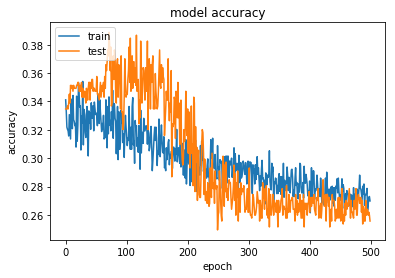

In [200]:
plot_training_history_acc(history, 'coffee_nn_clf')

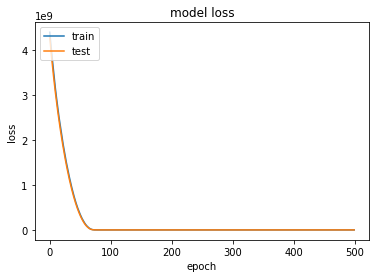

In [201]:
plot_training_history_loss(history, 'coffee_nn_clf')

Returns  0.00 %
Number of trades:  0
Number of short trades:  0
Number of long trades:  0
Earnings per trade:  0.00
Earnings per short trade:  0.00
Earnings per long trade:  0.00
Precision score:  [0.         0.39285714 0.        ]


/home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


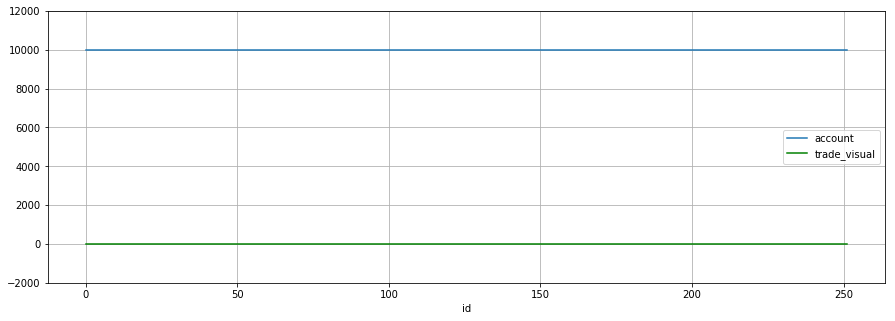

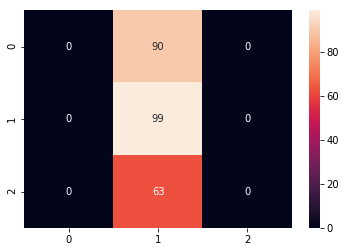

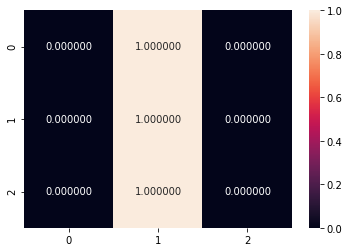

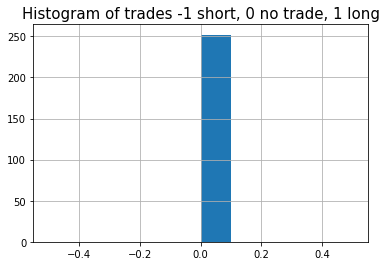

In [202]:
coffee_account_nn = get_performance(coffee_clf_nn, coffee_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_validate, coffee_label_validate, stop_loss_long=300, stop_loss_short=300, name='coffee_nn_cls')

# Neural network regressor

I have decided to use weighted in loss function with weight $0.75$. This is because errors around $0$ does not matter because I want to trigger trades when volatility reaches threshold.

Model performance
---


| commodity | gains % | earnings per trade | number of trades | test/real correlation |
|-----------|---------|--------------------|------------------|-----------------------|
| gold      | 232     | 180                | 129              | 0.14                  |
| corn      | -74     | -65                | 113              | -0.025                |
| coffee   | -12.92  | -56                | 23               | -0.020                |

In [213]:
import keras
import tensorflow as tf
from tensorflow.losses import mean_squared_error
from keras.optimizers import Nadam


def huber_loss(y_true, y_pred):
    return tf.losses.huber_loss(y_true,y_pred)


def weighted_mean_squared_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, weights=0.75)


# loss = huber_loss
loss = weighted_mean_squared_error
# optimizer = 'Adam'
optimizer = Nadam(lr=0.0001)

def regressor_model():
    global input_shape
    global loss
    global optimizer
    
    alpha=.0001
    model = Sequential()
    model.add(Dense(500, input_dim=input_shape, kernel_initializer='normal', activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dropout(0.4))
    model.add(Dense(128, kernel_initializer='normal',activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(64, kernel_initializer='normal',activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(32, kernel_initializer='normal',activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer, metrics=["mean_squared_error"])
    return model

    # model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
    # model.compile(loss='l1', optimizer='sgd', metrics=['mse'])
    # return model

In [216]:
X = pca_transform(gold_reg_train, gold_reg_pca)
y = gold_reg_label_train
# remove outliers
X, y = remove_outliers(X, y, out_gold)

X_test = pca_transform(gold_reg_test, gold_reg_pca)
y_test = gold_reg_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_gold)

epochs = 500
batch_size = 50

checkpointer = ModelCheckpoint(filepath='saved_models/weights.gold_reg.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

estimator = KerasRegressor(build_fn=regressor_model, epochs=epochs, batch_size=batch_size)

In [217]:
history = estimator.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

Train on 1927 samples, validate on 484 samples
Epoch 1/500
1927/1927 [==============================] - 2s 1ms/step - loss: 1279822.0998 - mean_squared_error: 1706429.4993 - val_loss: 1215191.8308 - val_mean_squared_error: 1620255.8329

Epoch 00001: val_loss improved from inf to 1215191.83084, saving model to saved_models/weights.gold_reg.hdf5
Epoch 2/500
1927/1927 [==============================] - 0s 125us/step - loss: 1279820.4385 - mean_squared_error: 1706427.2113 - val_loss: 1215189.8512 - val_mean_squared_error: 1620253.0509

Epoch 00002: val_loss improved from 1215191.83084 to 1215189.85124, saving model to saved_models/weights.gold_reg.hdf5
Epoch 3/500
1927/1927 [==============================] - 0s 127us/step - loss: 1279794.1209 - mean_squared_error: 1706392.1567 - val_loss: 1215188.3691 - val_mean_squared_error: 1620251.1826

Epoch 00003: val_loss improved from 1215189.85124 to 1215188.36906, saving model to saved_models/weights.gold_reg.hdf5
Epoch 4/500
1927/1927 [=========


Epoch 00027: val_loss improved from 1215104.80527 to 1215093.27040, saving model to saved_models/weights.gold_reg.hdf5
Epoch 28/500
1927/1927 [==============================] - 0s 121us/step - loss: 1278697.4931 - mean_squared_error: 1704929.9669 - val_loss: 1215074.3146 - val_mean_squared_error: 1620099.0793

Epoch 00028: val_loss improved from 1215093.27040 to 1215074.31457, saving model to saved_models/weights.gold_reg.hdf5
Epoch 29/500
1927/1927 [==============================] - 0s 122us/step - loss: 1278662.9558 - mean_squared_error: 1704883.9486 - val_loss: 1215058.6059 - val_mean_squared_error: 1620078.1893

Epoch 00029: val_loss improved from 1215074.31457 to 1215058.60589, saving model to saved_models/weights.gold_reg.hdf5
Epoch 30/500
1927/1927 [==============================] - 0s 122us/step - loss: 1278517.9035 - mean_squared_error: 1704690.5553 - val_loss: 1215042.1302 - val_mean_squared_error: 1620056.1402

Epoch 00030: val_loss improved from 1215058.60589 to 1215042.13

1927/1927 [==============================] - 0s 126us/step - loss: 1273725.9789 - mean_squared_error: 1698301.3269 - val_loss: 1214721.8910 - val_mean_squared_error: 1619629.2929

Epoch 00055: val_loss did not improve from 1214707.37758
Epoch 56/500
1927/1927 [==============================] - 0s 129us/step - loss: 1273731.5414 - mean_squared_error: 1698308.7792 - val_loss: 1214720.3179 - val_mean_squared_error: 1619627.1033

Epoch 00056: val_loss did not improve from 1214707.37758
Epoch 57/500
1927/1927 [==============================] - 0s 122us/step - loss: 1273117.0521 - mean_squared_error: 1697489.3683 - val_loss: 1214693.4068 - val_mean_squared_error: 1619591.2655

Epoch 00057: val_loss improved from 1214707.37758 to 1214693.40677, saving model to saved_models/weights.gold_reg.hdf5
Epoch 58/500
1927/1927 [==============================] - 0s 121us/step - loss: 1272942.3736 - mean_squared_error: 1697256.5053 - val_loss: 1214701.7565 - val_mean_squared_error: 1619602.3161

Epoch 00


Epoch 00083: val_loss did not improve from 1214316.17020
Epoch 84/500
1927/1927 [==============================] - 0s 155us/step - loss: 1266410.5643 - mean_squared_error: 1688547.4290 - val_loss: 1214329.1839 - val_mean_squared_error: 1619105.6222

Epoch 00084: val_loss did not improve from 1214316.17020
Epoch 85/500
1927/1927 [==============================] - 0s 126us/step - loss: 1266263.9886 - mean_squared_error: 1688351.9835 - val_loss: 1214331.9615 - val_mean_squared_error: 1619109.2931

Epoch 00085: val_loss did not improve from 1214316.17020
Epoch 86/500
1927/1927 [==============================] - 0s 122us/step - loss: 1265766.7062 - mean_squared_error: 1687688.9552 - val_loss: 1214309.5310 - val_mean_squared_error: 1619079.3964

Epoch 00086: val_loss improved from 1214316.17020 to 1214309.53099, saving model to saved_models/weights.gold_reg.hdf5
Epoch 87/500
1927/1927 [==============================] - 0s 124us/step - loss: 1265921.3036 - mean_squared_error: 1687895.0499 - 


Epoch 00113: val_loss did not improve from 1213944.58161
Epoch 114/500
1927/1927 [==============================] - 0s 127us/step - loss: 1258563.8121 - mean_squared_error: 1678085.0543 - val_loss: 1214036.3334 - val_mean_squared_error: 1618715.1255

Epoch 00114: val_loss did not improve from 1213944.58161
Epoch 115/500
1927/1927 [==============================] - 0s 122us/step - loss: 1257200.5372 - mean_squared_error: 1676267.4094 - val_loss: 1214102.9223 - val_mean_squared_error: 1618803.8776

Epoch 00115: val_loss did not improve from 1213944.58161
Epoch 116/500
1927/1927 [==============================] - 0s 126us/step - loss: 1257965.2932 - mean_squared_error: 1677287.0672 - val_loss: 1214037.1268 - val_mean_squared_error: 1618716.1601

Epoch 00116: val_loss did not improve from 1213944.58161
Epoch 117/500
1927/1927 [==============================] - 0s 124us/step - loss: 1256766.8384 - mean_squared_error: 1675689.1430 - val_loss: 1214039.2203 - val_mean_squared_error: 1618719.0

1927/1927 [==============================] - 0s 127us/step - loss: 1247863.3378 - mean_squared_error: 1663817.8119 - val_loss: 1213641.7038 - val_mean_squared_error: 1618188.9137

Epoch 00144: val_loss did not improve from 1213589.64127
Epoch 145/500
1927/1927 [==============================] - 0s 120us/step - loss: 1246277.6856 - mean_squared_error: 1661703.5646 - val_loss: 1213712.3360 - val_mean_squared_error: 1618283.1547

Epoch 00145: val_loss did not improve from 1213589.64127
Epoch 146/500
1927/1927 [==============================] - 0s 125us/step - loss: 1247338.7108 - mean_squared_error: 1663118.2715 - val_loss: 1213653.8308 - val_mean_squared_error: 1618205.0997

Epoch 00146: val_loss did not improve from 1213589.64127
Epoch 147/500
1927/1927 [==============================] - 0s 121us/step - loss: 1246435.3981 - mean_squared_error: 1661913.8514 - val_loss: 1213593.4073 - val_mean_squared_error: 1618124.5444

Epoch 00147: val_loss did not improve from 1213589.64127
Epoch 148/

1927/1927 [==============================] - 0s 123us/step - loss: 1236811.5390 - mean_squared_error: 1649082.0542 - val_loss: 1213126.9659 - val_mean_squared_error: 1617502.6103

Epoch 00174: val_loss did not improve from 1212928.62087
Epoch 175/500
1927/1927 [==============================] - 0s 121us/step - loss: 1236200.7925 - mean_squared_error: 1648267.7446 - val_loss: 1213069.3257 - val_mean_squared_error: 1617425.7330

Epoch 00175: val_loss did not improve from 1212928.62087
Epoch 176/500
1927/1927 [==============================] - 0s 123us/step - loss: 1236731.0956 - mean_squared_error: 1648974.8084 - val_loss: 1212916.6831 - val_mean_squared_error: 1617222.2534

Epoch 00176: val_loss improved from 1212928.62087 to 1212916.68311, saving model to saved_models/weights.gold_reg.hdf5
Epoch 177/500
1927/1927 [==============================] - 0s 123us/step - loss: 1234666.3520 - mean_squared_error: 1646221.7832 - val_loss: 1212770.3275 - val_mean_squared_error: 1617027.0152

Epoch

1927/1927 [==============================] - 0s 123us/step - loss: 1223600.9768 - mean_squared_error: 1631467.9581 - val_loss: 1212737.0424 - val_mean_squared_error: 1616982.7030

Epoch 00206: val_loss did not improve from 1212736.33239
Epoch 207/500
1927/1927 [==============================] - 0s 162us/step - loss: 1222482.5437 - mean_squared_error: 1629976.7141 - val_loss: 1212660.1883 - val_mean_squared_error: 1616880.2262

Epoch 00207: val_loss improved from 1212736.33239 to 1212660.18827, saving model to saved_models/weights.gold_reg.hdf5
Epoch 208/500
1927/1927 [==============================] - 0s 130us/step - loss: 1221432.0190 - mean_squared_error: 1628575.9840 - val_loss: 1212799.6457 - val_mean_squared_error: 1617066.1774

Epoch 00208: val_loss did not improve from 1212660.18827
Epoch 209/500
1927/1927 [==============================] - 0s 122us/step - loss: 1220528.7798 - mean_squared_error: 1627371.7005 - val_loss: 1212644.0643 - val_mean_squared_error: 1616858.7469

Epoch

1927/1927 [==============================] - 0s 122us/step - loss: 1209685.4933 - mean_squared_error: 1612914.0138 - val_loss: 1212401.2701 - val_mean_squared_error: 1616535.0705

Epoch 00236: val_loss did not improve from 1212366.84375
Epoch 237/500
1927/1927 [==============================] - 0s 121us/step - loss: 1210584.7571 - mean_squared_error: 1614112.9878 - val_loss: 1212436.5710 - val_mean_squared_error: 1616582.0671

Epoch 00237: val_loss did not improve from 1212366.84375
Epoch 238/500
1927/1927 [==============================] - 0s 122us/step - loss: 1206270.2266 - mean_squared_error: 1608360.2975 - val_loss: 1212455.1981 - val_mean_squared_error: 1616606.8946

Epoch 00238: val_loss did not improve from 1212366.84375
Epoch 239/500
1927/1927 [==============================] - 0s 121us/step - loss: 1205921.3973 - mean_squared_error: 1607895.1971 - val_loss: 1212441.6632 - val_mean_squared_error: 1616588.8796

Epoch 00239: val_loss did not improve from 1212366.84375
Epoch 240/


Epoch 00267: val_loss did not improve from 1212081.03822
Epoch 268/500
1927/1927 [==============================] - 0s 121us/step - loss: 1193789.0096 - mean_squared_error: 1591718.7195 - val_loss: 1211987.1049 - val_mean_squared_error: 1615982.7722

Epoch 00268: val_loss improved from 1212081.03822 to 1211987.10486, saving model to saved_models/weights.gold_reg.hdf5
Epoch 269/500
1927/1927 [==============================] - 0s 119us/step - loss: 1192825.0689 - mean_squared_error: 1590433.4605 - val_loss: 1211923.3329 - val_mean_squared_error: 1615897.8066

Epoch 00269: val_loss improved from 1211987.10486 to 1211923.33290, saving model to saved_models/weights.gold_reg.hdf5
Epoch 270/500
1927/1927 [==============================] - 0s 122us/step - loss: 1189612.9886 - mean_squared_error: 1586150.6512 - val_loss: 1212059.3138 - val_mean_squared_error: 1616079.1273

Epoch 00270: val_loss did not improve from 1211923.33290
Epoch 271/500
1927/1927 [==============================] - 0s 143

Epoch 299/500
1927/1927 [==============================] - 0s 133us/step - loss: 1175969.5908 - mean_squared_error: 1567959.4350 - val_loss: 1211437.1692 - val_mean_squared_error: 1615249.5529

Epoch 00299: val_loss did not improve from 1211373.84401
Epoch 300/500
1927/1927 [==============================] - 0s 131us/step - loss: 1173368.2140 - mean_squared_error: 1564490.9595 - val_loss: 1211495.4494 - val_mean_squared_error: 1615327.2758

Epoch 00300: val_loss did not improve from 1211373.84401
Epoch 301/500
1927/1927 [==============================] - 0s 133us/step - loss: 1172974.8405 - mean_squared_error: 1563966.4395 - val_loss: 1211603.0710 - val_mean_squared_error: 1615470.7727

Epoch 00301: val_loss did not improve from 1211373.84401
Epoch 302/500
1927/1927 [==============================] - 0s 145us/step - loss: 1175072.2631 - mean_squared_error: 1566763.0314 - val_loss: 1211447.3407 - val_mean_squared_error: 1615263.1118

Epoch 00302: val_loss did not improve from 1211373.84

1927/1927 [==============================] - 0s 129us/step - loss: 1160195.4029 - mean_squared_error: 1546927.2303 - val_loss: 1211458.8533 - val_mean_squared_error: 1615278.3639

Epoch 00330: val_loss did not improve from 1210911.83781
Epoch 331/500
1927/1927 [==============================] - 0s 128us/step - loss: 1157550.2684 - mean_squared_error: 1543400.3307 - val_loss: 1211235.6963 - val_mean_squared_error: 1614980.9344

Epoch 00331: val_loss did not improve from 1210911.83781
Epoch 332/500
1927/1927 [==============================] - 0s 128us/step - loss: 1155243.4006 - mean_squared_error: 1540324.5428 - val_loss: 1211326.2820 - val_mean_squared_error: 1615101.6358

Epoch 00332: val_loss did not improve from 1210911.83781
Epoch 333/500
1927/1927 [==============================] - 0s 129us/step - loss: 1155342.9925 - mean_squared_error: 1540457.3439 - val_loss: 1211504.9202 - val_mean_squared_error: 1615339.9267

Epoch 00333: val_loss did not improve from 1210911.83781
Epoch 334/


Epoch 00362: val_loss did not improve from 1210911.83781
Epoch 363/500
1927/1927 [==============================] - 0s 124us/step - loss: 1138634.3692 - mean_squared_error: 1518179.1479 - val_loss: 1210860.8407 - val_mean_squared_error: 1614481.1565

Epoch 00363: val_loss improved from 1210911.83781 to 1210860.84065, saving model to saved_models/weights.gold_reg.hdf5
Epoch 364/500
1927/1927 [==============================] - 0s 118us/step - loss: 1137408.2881 - mean_squared_error: 1516544.3809 - val_loss: 1210750.1498 - val_mean_squared_error: 1614333.6126

Epoch 00364: val_loss improved from 1210860.84065 to 1210750.14979, saving model to saved_models/weights.gold_reg.hdf5
Epoch 365/500
1927/1927 [==============================] - 0s 127us/step - loss: 1137638.5831 - mean_squared_error: 1516851.4405 - val_loss: 1210890.7903 - val_mean_squared_error: 1614521.0408

Epoch 00365: val_loss did not improve from 1210750.14979
Epoch 366/500
1927/1927 [==============================] - 0s 128


Epoch 00394: val_loss did not improve from 1210684.17149
Epoch 395/500
1927/1927 [==============================] - 0s 140us/step - loss: 1117501.0979 - mean_squared_error: 1490001.4692 - val_loss: 1211310.6067 - val_mean_squared_error: 1615080.8507

Epoch 00395: val_loss did not improve from 1210684.17149
Epoch 396/500
1927/1927 [==============================] - 0s 139us/step - loss: 1115858.0759 - mean_squared_error: 1487810.7900 - val_loss: 1211100.4731 - val_mean_squared_error: 1614800.5669

Epoch 00396: val_loss did not improve from 1210684.17149
Epoch 397/500
1927/1927 [==============================] - 0s 141us/step - loss: 1112059.8438 - mean_squared_error: 1482746.4860 - val_loss: 1211459.9047 - val_mean_squared_error: 1615279.8778

Epoch 00397: val_loss did not improve from 1210684.17149
Epoch 398/500
1927/1927 [==============================] - 0s 139us/step - loss: 1118560.9483 - mean_squared_error: 1491414.5863 - val_loss: 1211371.0560 - val_mean_squared_error: 1615161.4

1927/1927 [==============================] - 0s 155us/step - loss: 1093311.0479 - mean_squared_error: 1457748.0736 - val_loss: 1212065.0912 - val_mean_squared_error: 1616086.8140

Epoch 00427: val_loss did not improve from 1210684.17149
Epoch 428/500
1927/1927 [==============================] - 0s 155us/step - loss: 1093942.8179 - mean_squared_error: 1458590.3855 - val_loss: 1211874.6183 - val_mean_squared_error: 1615832.7874

Epoch 00428: val_loss did not improve from 1210684.17149
Epoch 429/500
1927/1927 [==============================] - 0s 155us/step - loss: 1093437.8018 - mean_squared_error: 1457917.0509 - val_loss: 1212184.6940 - val_mean_squared_error: 1616246.2146

Epoch 00429: val_loss did not improve from 1210684.17149
Epoch 430/500
1927/1927 [==============================] - 0s 155us/step - loss: 1093994.9698 - mean_squared_error: 1458659.9539 - val_loss: 1212035.6870 - val_mean_squared_error: 1616047.5537

Epoch 00430: val_loss did not improve from 1210684.17149
Epoch 431/


Epoch 00459: val_loss did not improve from 1210684.17149
Epoch 460/500
1927/1927 [==============================] - 0s 155us/step - loss: 1072779.7806 - mean_squared_error: 1430373.0775 - val_loss: 1212538.0134 - val_mean_squared_error: 1616717.3817

Epoch 00460: val_loss did not improve from 1210684.17149
Epoch 461/500
1927/1927 [==============================] - 0s 155us/step - loss: 1071419.8919 - mean_squared_error: 1428559.8547 - val_loss: 1212776.6506 - val_mean_squared_error: 1617035.5470

Epoch 00461: val_loss did not improve from 1210684.17149
Epoch 462/500
1927/1927 [==============================] - 0s 157us/step - loss: 1072965.9955 - mean_squared_error: 1430621.3694 - val_loss: 1212799.3409 - val_mean_squared_error: 1617065.8042

Epoch 00462: val_loss did not improve from 1210684.17149
Epoch 463/500
1927/1927 [==============================] - 0s 134us/step - loss: 1067962.1378 - mean_squared_error: 1423949.4986 - val_loss: 1212292.5759 - val_mean_squared_error: 1616390.0

1927/1927 [==============================] - 0s 129us/step - loss: 1054747.7357 - mean_squared_error: 1406330.3119 - val_loss: 1214878.8376 - val_mean_squared_error: 1619838.4556

Epoch 00492: val_loss did not improve from 1210684.17149
Epoch 493/500
1927/1927 [==============================] - 0s 124us/step - loss: 1050303.6073 - mean_squared_error: 1400404.8029 - val_loss: 1214411.6666 - val_mean_squared_error: 1619215.5480

Epoch 00493: val_loss did not improve from 1210684.17149
Epoch 494/500
1927/1927 [==============================] - 0s 133us/step - loss: 1048144.1032 - mean_squared_error: 1397525.4274 - val_loss: 1214765.5914 - val_mean_squared_error: 1619687.4897

Epoch 00494: val_loss did not improve from 1210684.17149
Epoch 495/500
1927/1927 [==============================] - 0s 131us/step - loss: 1047797.0198 - mean_squared_error: 1397062.6939 - val_loss: 1214467.1333 - val_mean_squared_error: 1619289.5323

Epoch 00495: val_loss did not improve from 1210684.17149
Epoch 496/

In [206]:
plot_training_history_acc(history, 'gold_nn_reg')

dict_keys(['val_loss', 'loss'])


KeyError: 'acc'

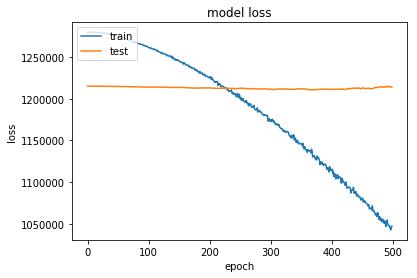

In [218]:
plot_training_history_loss(history, 'gold_nn_reg')

In [219]:
history.history.keys()

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])

In [224]:
def plot_training_history_mse(history, name):
    # history = model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, verbose=0)
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    # plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.title('Mean squared error')
    plt.ylabel('MSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.show()
    plt.savefig('figures/' + name + '_keras_accuracy.eps')

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


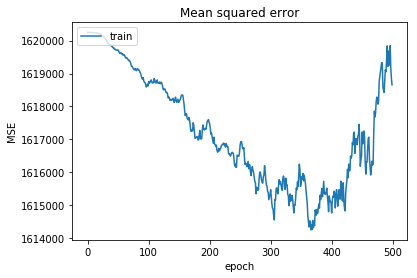

In [225]:
plot_training_history_mse(history, 'gold_nn_reg')

In [ ]:
model = regressor_model()
model.load_weights('saved_models/weights.gold_reg.hdf5')
gold_clf_reg_nn = model

In [ ]:
gold_account_nn = get_performance(gold_clf_reg_nn, gold_reg_pca, gold_gains.loc[gold_gains.index > validate_date], gold_reg_validate, gold_reg_label_validate, stop_loss_long=1000, stop_loss_short=800, regression=True, target=10, name='gold_nn_reg')

In [ ]:
X = pca_transform(corn_reg_train, corn_reg_pca)
y = corn_reg_label_train
# remove outliers
X, y = remove_outliers(X, y, out_corn)

X_test = pca_transform(corn_reg_test, corn_reg_pca)
y_test = corn_reg_label_test
# remove outliers
X_test, y_test = remove_outliers(X_test, y_test, out_corn)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.corn_reg.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

estimator = KerasRegressor(build_fn=regressor_model, epochs=50, batch_size=50)
history = estimator.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

In [ ]:
plot_training_history_acc(history, 'corn_nn_reg')

In [ ]:
plot_training_history_loss(history, 'corn_nn_reg')

In [ ]:
model = regressor_model()
model.load_weights('saved_models/weights.corn_reg.hdf5')
corn_clf_reg_nn = model

In [ ]:
corn_account_nn = get_performance(corn_clf_reg_nn, corn_reg_pca, corn_gains.loc[corn_gains.index > validate_date], corn_reg_validate, corn_reg_label_validate, stop_loss_long=300, stop_loss_short=300, regression=True, target=0.1, name='corn_nn_reg')

In [ ]:
X = pca_transform(coffee_reg_train, coffee_reg_pca)
y = coffee_reg_label_train
# remove outliers
X, y = remove_outliers(X, y, out_corn)

X_test = pca_transform(coffee_reg_test, coffee_reg_pca)
y_test = coffee_reg_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_corn)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.coffee_reg.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

estimator = KerasRegressor(build_fn=regressor_model, epochs=epochs, batch_size=batch_size)
history = estimator.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

In [ ]:
plot_training_history_acc(history, 'coffee_nn_reg')

In [ ]:
plot_training_history_loss(history, 'coffee_nn_reg')

In [ ]:
model = regressor_model()
model.load_weights('saved_models/weights.coffee_reg.hdf5')
coffee_clf_reg_nn = model

In [ ]:
coffee_account_nn = get_performance(coffee_clf_reg_nn, coffee_reg_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_reg_validate, coffee_reg_label_validate, stop_loss_long=1000, stop_loss_short=1000, regression=True, target=0.1, name='coffee_nn_reg')

# Conclusions
Only Gold regressor has data that returns positive results. Correlation between actual gold price and predictions is around $0.15$ (depending on training).

Corn and Coffee has rather random correlation with actual performance (also training is not going well).
Last weights update for keras neural network regressor (1000 epochs):

| Gold | Corn | Coffee |
|------|------|--------|
| 512  |   32 | 1      |

I am surprised that I cannot achieve better results with corn. Since corn retained most information by PCA transformation. I expected to have best training results with corn.

# H2O AutoML experiment

In [ ]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

### Classification
Based on the H2O documentation only 2 categories are supported for AutoML. This model was generated for long trades.

In [ ]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_long_train.csv", header=1)
validation = h2o.import_file("data/gold_pca_long_validation.csv", header=1)
test = h2o.import_file("data/gold_pca_long_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
validation[y] = validation[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

In [ ]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

In [ ]:
gold_account = get_account(b, gold_gains.loc[gold_gains.index > validate_date], gold_label_validate, stop_loss_long=1000, stop_loss_short=800, name='gold_long_automl_clf')

### H2O AutoML gold regressor

In [ ]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_reg_train.csv", header=1)
validation = h2o.import_file("data/gold_pca_reg_validation.csv", header=1)
test = h2o.import_file("data/gold_pca_reg_test.csv", header=1)

# Identify predictors and response
print(train.head())
x = train.columns
y = "label"
x.remove(y)

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=40, max_runtime_secs=60, seed=1234, stopping_metric='deviance')
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

In [ ]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

In [ ]:
b

In [ ]:
def trade(x, treshold):
    ans = 0
    if abs(x) > treshold:
        if x > 0:
            ans = 1
        else:
            ans = -1
    return 0



preds = list(map(lambda x: trade(x, 200), b))

In [ ]:
print(preds)

In [ ]:
gold_account_reg = get_account(b, gold_gains.loc[gold_gains.index > validate_date], gold_label_validate, stop_loss_long=1000, stop_loss_short=800, regression=True,  name='gold_automl_reg')

### H2O short trade

In [ ]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_short_train.csv", header=1)
validation = h2o.import_file("data/gold_pca_short_validation.csv", header=1)
test = h2o.import_file("data/gold_pca_short_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
validation[y] = validation[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

In [ ]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = list(map(lambda x: -1 if x > 0 else 0, a.predict.values))
a.hist()

In [ ]:
gold_account = get_account(b, gold_gains.loc[gold_gains.index > validate_date], gold_label_validate, stop_loss_long=1000, stop_loss_short=800,  name='gold_automl_short_clf')

In [ ]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/corn_pca_short_train.csv", header=1)
validation = h2o.import_file("data/corn_pca_short_validation.csv", header=1)
test = h2o.import_file("data/corn_pca_short_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
validation[y] = validation[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

In [ ]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.map(lambda x: -1 if x > 0 else 0).values
a.hist()

In [ ]:
corn_account = get_account(b, corn_gains.loc[corn_gains.index > validate_date], corn_label_validate, stop_loss_long=300, stop_loss_short=300, name='corn_automl_short_clf')

In [ ]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/corn_pca_long_train.csv", header=1)
validation = h2o.import_file("data/corn_pca_long_validation.csv", header=1)
test = h2o.import_file("data/corn_pca_long_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
validation[y] = validation[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

In [ ]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

In [ ]:
corn_account = get_account(b, corn_gains.loc[corn_gains.index > validate_date], corn_label_validate, stop_loss_long=300, stop_loss_short=300, , name='corn_automl_long_clf')

In [ ]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/coffee_pca_long_train.csv", header=1)
validation = h2o.import_file("data/coffee_pca_long_validation.csv", header=1)
test = h2o.import_file("data/coffee_pca_long_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

In [ ]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

coffee_account = get_account(b, coffee_gains.loc[coffee_gains.index > validate_date], coffee_label_validate, stop_loss_long=800, stop_loss_short=800, , name='coffee_automl_short_clf')

In [ ]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/coffee_pca_short_train.csv", header=1)
validation = h2o.import_file("data/coffee_pca_long_validation.csv", header=1)
test = h2o.import_file("data/coffee_pca_short_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

In [ ]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.map(lambda x: -1 if x == 1 else 0).values
a.hist()

coffee_account = get_account(b, coffee_gains.loc[coffee_gains.index > validate_date], coffee_label_validate, stop_loss_long=800, stop_loss_short=800, , name='coffee_automl_short_clf')

# H2O AutoML conclusion

AutoML regression results were very disappointing since all the predictions for gold were around -26 (which is mean value of training data). Classifiers seems to work better. I think you could get some information but overall I think it is necessary to get insight into the data.

In [ ]:
# mean reversal
# Compute the z-scores for each day using the historical data up to that day
def mean_reversal_account(df, df_gains, trade_days=1):
    account = 10000
    direction = gold['mean_direction'].values[0]
    dct = {}
    dct['account'] = [account]
    trade = 0
    for d, v in zip(df['mean_direction'].values, gold_gains.values):
        if d >= 0 and direction <= 0:
            account -= v[0]
            trade += 1
            if trade_days == trade:
                direction = d
                trade = 0
        elif d <= 0 and direction >= 0:
            direction = d
            account += v[0]
            trade += 1
            if trade_days == trade:
                direction = d
                trade = 0
        dct['account'].append(account)
        if account <= 0:
            break
    return pd.DataFrame.from_dict(dct)

def mean_calculation(df, big_range, small_range):
    big_mean = 'mean_' + str(big_range)
    small_mean = 'mean_' + str(small_range)
    df[big_mean] = df.rolling(str(big_range) + 'd')['Settle'].apply(np.mean, raw=False)
    df[small_mean] = df.rolling(str(small_range) + 'd')['Settle'].apply(np.mean, raw=False)
    df['mean_direction'] =  df[small_mean] - df[big_mean]
    return df

# Comparison of performances

Below we will look at the comparison of the best trading strategy for each commodity versus mean reversal strategy and Nasdaq.

In [ ]:
gold = mean_calculation(gold, 20, 10)
gold[['Settle', 'mean_20', 'mean_10']].loc[gold.index > validate_date].plot(figsize=(10,5), grid=True)
savefig('figures/gold_mean_reversal.eps')

In [ ]:
nasdaq_amount = 10000/nasdaq.loc[(nasdaq.index >= '2018-01-02') & (nasdaq.index < '2018-01-03')].Settle.values[0]

nasdaq = nasdaq.loc[(nasdaq.index <= '2018-12-30')]

In [ ]:
nasdaq.loc[(nasdaq.index >= '2018-01-02') & (nasdaq.index < '2018-01-03')].Settle.values[0]

In [ ]:
nasdaq_amount

In [ ]:
gold_mean = mean_reversal_account(gold.loc[gold.index > validate_date], gold_gains.loc[gold_gains.index > validate_date], trade_days=5)
gold_mean['base'] = gold_mean.account.apply(lambda x: 10000)
gold_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
gold_mean['Nasdaq'] = gold_mean['Nasdaq']*nasdaq_amount

# gold_account_nn = get_performance(gold_clf_reg_nn
ax = pd.concat([gold_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
               gold_account_nn.rename(columns={'account': 'Model Shorts'})[['Model Shorts']],
               ], axis=1).plot(figsize=(10,5), grid=True)

title = ax.set_title('Gold performance comparison', size=15)
savefig('figures/gold_benchmark_performance.eps')

In [ ]:
gold_mean.head()

In [ ]:
corn = mean_calculation(corn, 20, 10)
corn[['Settle', 'mean_10', 'mean_20']].loc[corn.index > validate_date].plot(figsize=(10,5), grid=True)

In [ ]:
corn_mean = mean_reversal_account(corn.loc[corn.index > validate_date], corn_gains.loc[corn_gains.index > validate_date], trade_days=3)
corn_mean['base'] = corn_mean.account.apply(lambda x: 10000)
corn_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
corn_mean['Nasdaq'] = corn_mean['Nasdaq']*nasdaq_amount

ax = pd.concat([corn_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
               corn_account_lgb.rename(columns={'account': 'Corn LightGBM'})[['Corn LightGBM']]], 
               axis=1).plot(figsize=(10,5), grid=True)

title = ax.set_title('Corn performance comparison', size=15)
savefig('figures/corn_benchmark_performance.eps')

In [ ]:
coffee = mean_calculation(coffee, 20, 10)
coffee[['Settle', 'mean_20', 'mean_10']].loc[coffee.index > validate_date].plot(figsize=(10,5), grid=True)

In [ ]:
coffee_mean = mean_reversal_account(coffee.loc[coffee.index > validate_date], 
                                    coffee_gains.loc[coffee_gains.index > validate_date], 
                                    trade_days=5)
coffee_mean['base'] = coffee_mean.account.apply(lambda x: 10000)
coffee_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
coffee_mean['Nasdaq'] = coffee_mean['Nasdaq']*nasdaq_amount

ax = pd.concat([coffee_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
                coffee_account_lgb.rename(columns={'account': 'Coffee LightGBM'})[['Coffee LightGBM']],
               ], axis=1).plot(figsize=(10,5), grid=True)
title = ax.set_title('Coffee performance comparison', size=15)
savefig('figures/coffee_benchmark_performance.eps')

# Conclusion

Trading is a difficult ML problem. Out of three compared commodities gold, corn and coffee we were able to predict performance with gold. Other commodities behaved randomly with approximately 0 correlation to the actual volatility.

In the beginning of project, I was thinking of a classifier (short, no trade, long) because it is closer to the usage of model. I tested regressor as well. Regressor works better because there is more information. I tried different loss function when training regressor. I decided to use weighted MSE. This could be further modified for better function omitting errors below threshold.

Gold trading is the most capital intensive with very big stop losses (1000 long, 800 short). This can be problem for trading with $10 000\$$ account.

In case of corn and coffee the data was almost impossible to classify. I suspect more data transformation is needed to get better results.